이번주는 three-classes lung segmentation을 영상 처리 기법을 사용하여 진행할 예정이다.

데이터 다운로드

데이터는 지난 주 segmentation 당시 사용했던 X-ray dataset을 그대로 사용하였음

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!wget https://github.com/younggon2/Education-ComputerVision-DeepLearning/raw/master/res/Lung_Segmentation.zip

--2025-02-28 02:00:29--  https://github.com/younggon2/Education-ComputerVision-DeepLearning/raw/master/res/Lung_Segmentation.zip
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/younggon2/Education-ComputerVision-DeepLearning/master/res/Lung_Segmentation.zip [following]
--2025-02-28 02:00:30--  https://media.githubusercontent.com/media/younggon2/Education-ComputerVision-DeepLearning/master/res/Lung_Segmentation.zip
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 56097894 (53M) [application/zip]
Saving to: ‘Lung_Segmentation.zip’

Lung_Segmentation.z 100%[===================>]  53.

In [ ]:
!unzip Lung_Segmentation.zip

Archive:  Lung_Segmentation.zip
  inflating: image/resize_CHNCXR_0001_0.png  
  inflating: image/resize_CHNCXR_0002_0.png  
  inflating: image/resize_CHNCXR_0003_0.png  
  inflating: image/resize_CHNCXR_0004_0.png  
  inflating: image/resize_CHNCXR_0005_0.png  
  inflating: image/resize_CHNCXR_0006_0.png  
  inflating: image/resize_CHNCXR_0007_0.png  
  inflating: image/resize_CHNCXR_0008_0.png  
  inflating: image/resize_CHNCXR_0009_0.png  
  inflating: image/resize_CHNCXR_0010_0.png  
  inflating: image/resize_CHNCXR_0011_0.png  
  inflating: image/resize_CHNCXR_0012_0.png  
  inflating: image/resize_CHNCXR_0013_0.png  
  inflating: image/resize_CHNCXR_0014_0.png  
  inflating: image/resize_CHNCXR_0015_0.png  
  inflating: image/resize_CHNCXR_0016_0.png  
  inflating: image/resize_CHNCXR_0017_0.png  
  inflating: image/resize_CHNCXR_0018_0.png  
  inflating: image/resize_CHNCXR_0019_0.png  
  inflating: image/resize_CHNCXR_0020_0.png  
  inflating: image/resize_CHNCXR_0021_0.png  
  

윤곽선 / 외곽선 검출 할 수 있는 OpenCV 라이브러리의 findcontour() 함수 사용해보려함

cv2.findContours() 함수는 이미지에서 윤곽선을 찾는데 사용되며 이진화된 이미지에서 객체의 외곽을 찾아내고 외곽선을 구성하는 점들을 반환

윤곽선 분석을 통한 lung segmentation

In [ ]:
#3개의 클래스로 나누되 mid 도입 대신 윤곽선 검출로 작업하기#

import os
import numpy as np
import cv2 #이미지 처리를 위한 라이브러리로 opencv 추가
from skimage.io import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split

IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3 #image를 256X256X3으로 진행

data_path = "/content/"

files = os.listdir(os.path.join(data_path, 'image'))
file_headers = []
for f in files:
    f1 = os.path.splitext(f)[0]
    file_headers.append(f1)

#print(file_headers) #이미지 폴더의 모든 파일들을 불러와 확장자를 제거하여 파일명을 가져온다

X_all = np.zeros((len(file_headers), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

y_all = np.zeros((len(file_headers),IMG_HEIGHT,IMG_WIDTH,3),dtype=np.float32)

count = 0 #X_all과 y_all이라는 빈 배열을 생성한다.


for fh in file_headers:
    f1 = os.path.join(data_path, 'image', '{}.png'.format(fh))
    l1 = os.path.join(data_path, 'label', '{}.png'.format(fh))

    img = imread(f1)[:,:,:IMG_CHANNELS]
    mask = imread(l1)

    #마스크를 원핫인코딩으로 변환
    mask_one_hot = np.zeros((IMG_HEIGHT,IMG_WIDTH,3),dtype=np.float32)

    #폐 영역(255)과 배경(0) 의 구분
    lung_mask = (mask == 255).astype(np.uint8) #폐 영역을 255로 설정
    background_mask = (mask == 0).astype(np.float32) #배경을 1로 설정

    #Opencv라이브러리의 findContours() 함수를 사용하여 폐 영역의 윤곽선을 검출
    contours, _ = cv2.findContours(lung_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    #lung_mask는 입력 이미지 (반드시 binary image여야함)
    #cv2.RETR_EXTERNAL은 가장 바깥쪽 윤곽선만 검출
    #cv2.CHAIN_APPROX_SIMPLE은 윤곽선을 근사화 하는 방법
    #반환값은 contours(윤곽선 목록)와 hierarchy(윤곽선 계층 구조,여기서는 ''로 무시)

    #노이즈를 제거하고 작은 윤곽선들을 필터링
    #print("원본 contour 개수",len(contours))
    contours = [c for c in contours if cv2.contourArea(c) > 0] #면적이 0이상인 것들만
    #print("필터링 후 contour 개수:",len(contours))

    #면적이 큰 순서대로 정렬하여 가장 큰 contour 2개 선택 (--> 좌,우 폐)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:2]

    #좌/우 폐를 지정할 빈 마스크를 생성
    left_mask = np.zeros_like(lung_mask,dtype=np.float32)
    right_mask = np.zeros_like(lung_mask,dtype=np.float32)

    #검출된 윤곽선이 2개일 경우 loop를 실행한다

    if len(contours) == 2:

        #각 윤곽선의 중심점을 계산
        centers = []
        for i,c in enumerate(contours):
            area=cv2.contourArea(c) #윤곽선의 면적 계산
            M = cv2.moments(c)      #윤곽선의 모멘트 계산
            if M["m00"] != 0:
                cx = int(M["m10"] / M["m00"]) #x좌표 중심점 계산
                #print(f"Contour {i}:면적 = {area},중심점 x = {cx}")
                centers.append((cx,c))

        #x좌표를 기준으로 정렬하여 좌,우를 구분
        centers.sort(key=lambda x : x[0])

        #우측 폐 (이미지 좌측)
        cv2.drawContours(right_mask,[centers[0][1]],-1,1,-1)

        #좌측 폐 (이미지 우측)
        cv2.drawContours(left_mask,[centers[1][1]],-1,1,-1)

    #각 채널에 마스크 할당
    mask_one_hot[:,:,0] = background_mask #배경
    mask_one_hot[:,:,1] = left_mask #왼쪽 폐 (이미지의 오른쪽)
    mask_one_hot[:,:,2] = right_mask #오른쪽 폐 (이미지의 왼쪽)

    #처리된 이미지와 마스크를 배열에 저장
    X_all[count] = img
    y_all[count] = mask_one_hot

    #처리된 이미지 카운트 증가
    count += 1

데이터 시각화

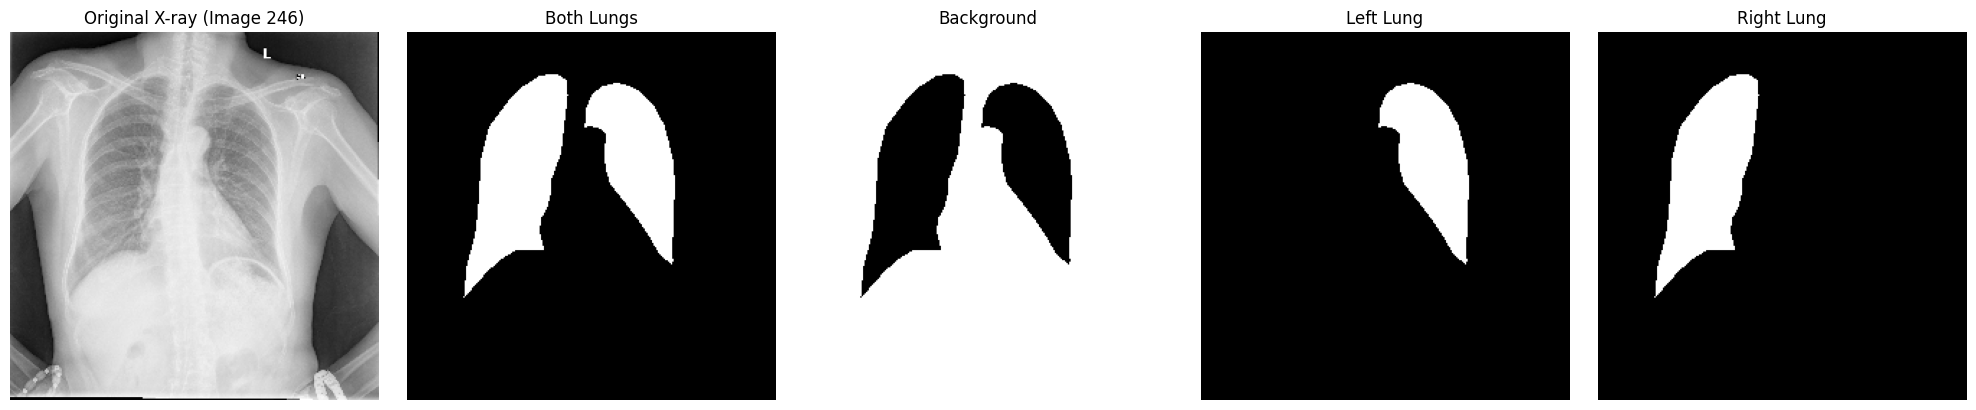

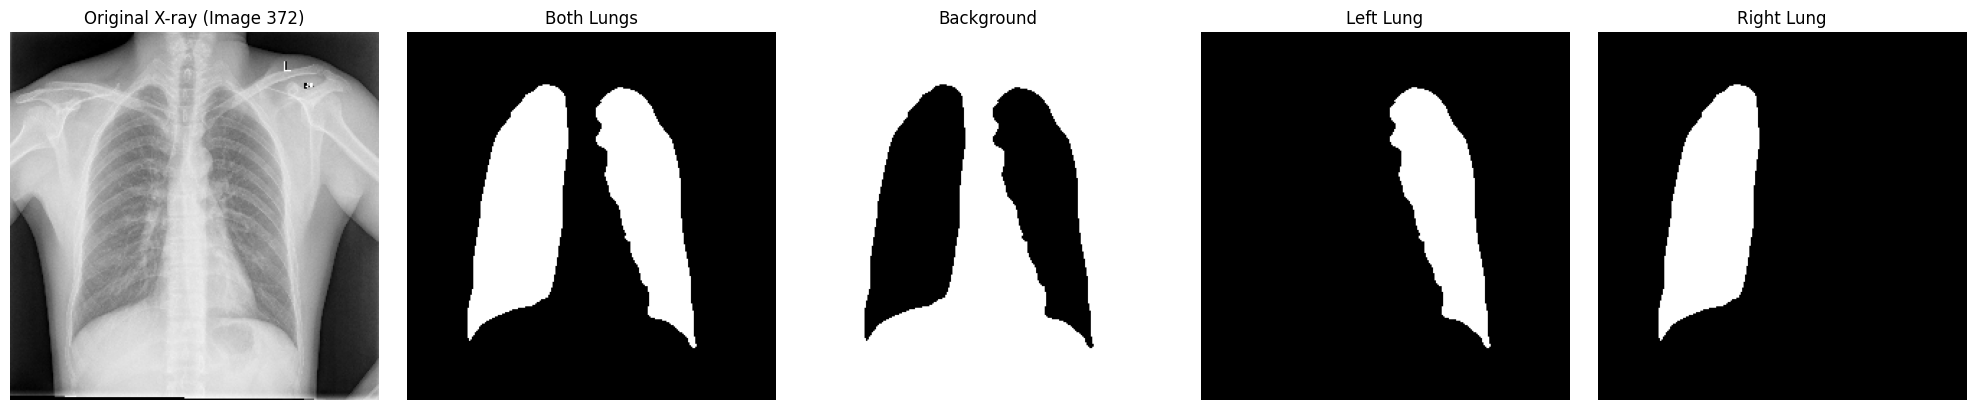

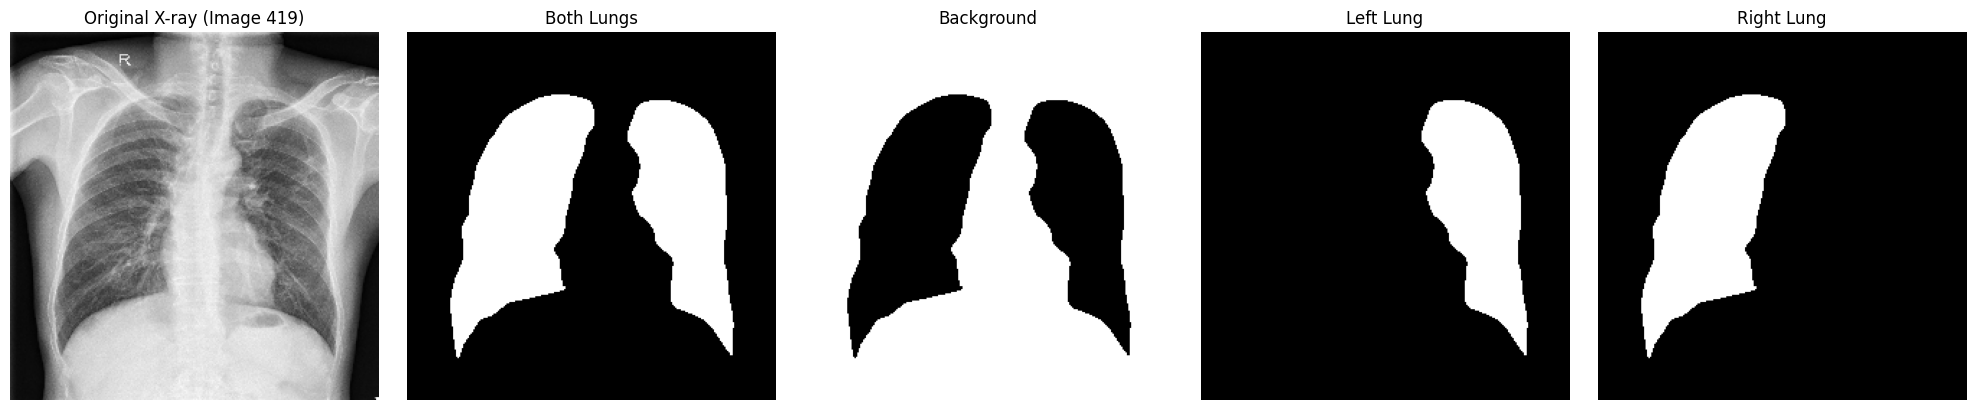

In [ ]:
import matplotlib.pyplot as plt

def visualize_watershed_results(X, y, num_samples=[246, 372, 419]):
    """
    특정 인덱스의 이미지에 대해 Watershed 분할 결과를 시각화하는 함수
    X: 원본 X-ray 이미지
    y: watershed로 분할된 마스크 (원-핫 인코딩)
    num_samples: 시각화할 이미지의 인덱스 리스트
    """
    for idx in num_samples:
        plt.figure(figsize=(20, 4))

        # 원본 X-ray 이미지
        plt.subplot(151)
        plt.title(f'Original X-ray (Image {idx})')
        plt.imshow(X[idx])
        plt.axis('off')

        # 전체 폐 마스크
        plt.subplot(152)
        plt.title('Both Lungs')
        plt.imshow(y[idx,:,:,1] + y[idx,:,:,2], cmap='gray')
        plt.axis('off')

        # 배경
        plt.subplot(153)
        plt.title('Background')
        plt.imshow(y[idx,:,:,0], cmap='gray')
        plt.axis('off')

        # 왼쪽 폐
        plt.subplot(154)
        plt.title('Left Lung')
        plt.imshow(y[idx,:,:,1], cmap='gray')
        plt.axis('off')

        # 오른쪽 폐
        plt.subplot(155)
        plt.title('Right Lung')
        plt.imshow(y[idx,:,:,2], cmap='gray')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

# 시각화 실행 (246번, 372번, 419번 이미지)
visualize_watershed_results(X_all, y_all)


=== Random Sample Contour Results ===

Image 128


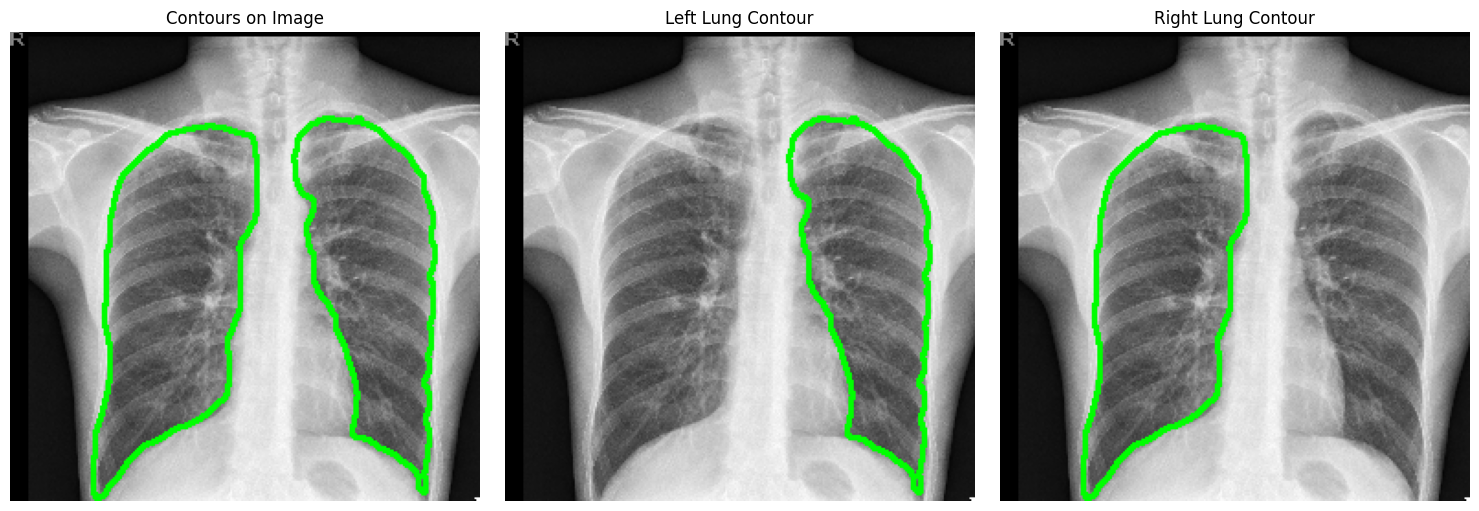


Image 262


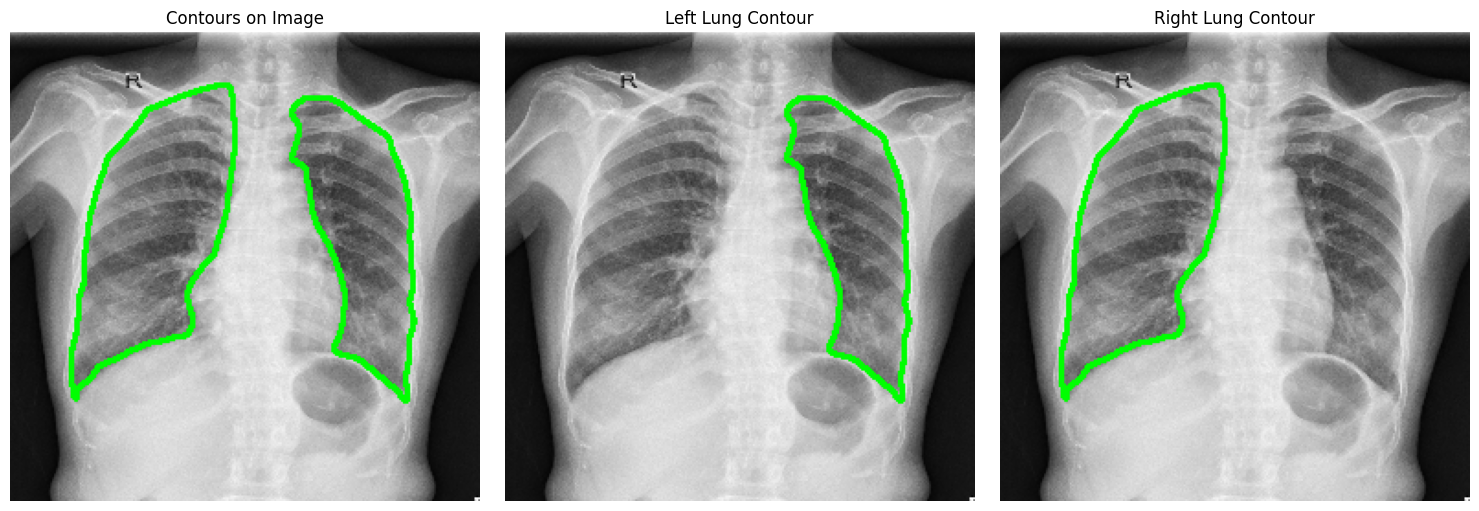


Image 307


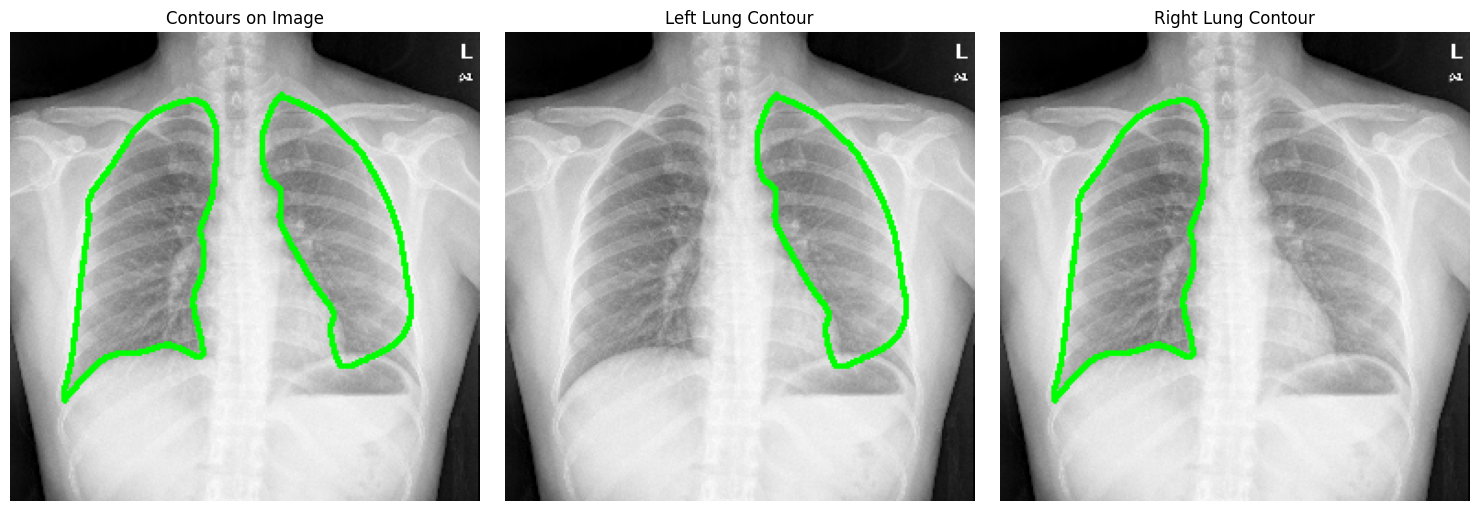


Image 36


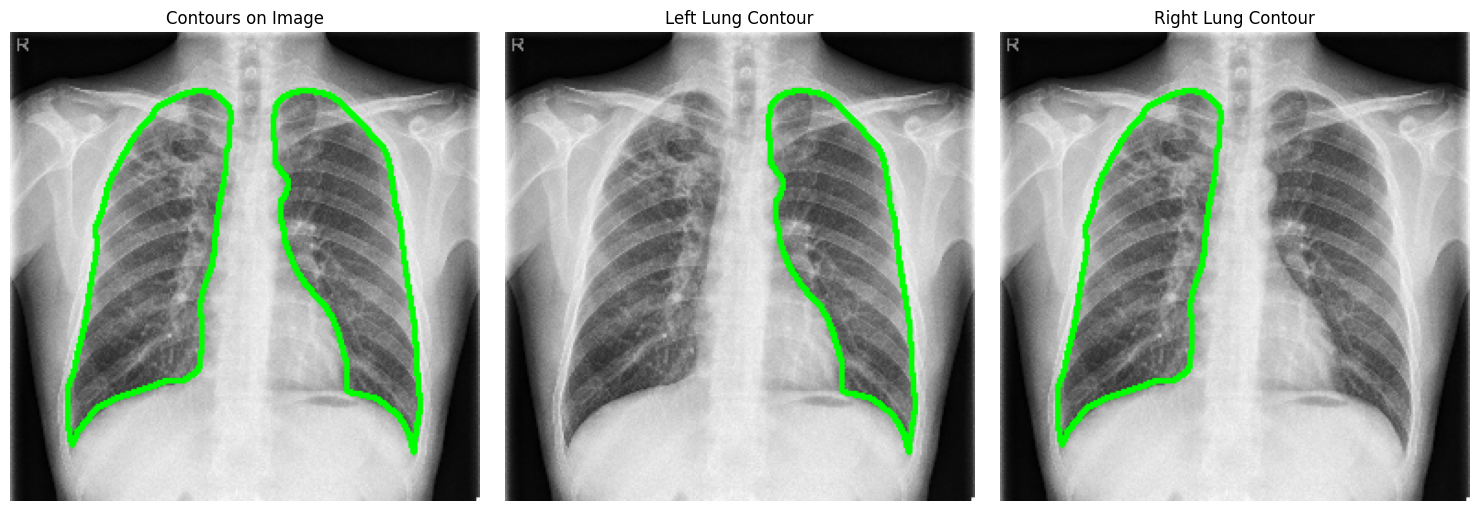


Image 397


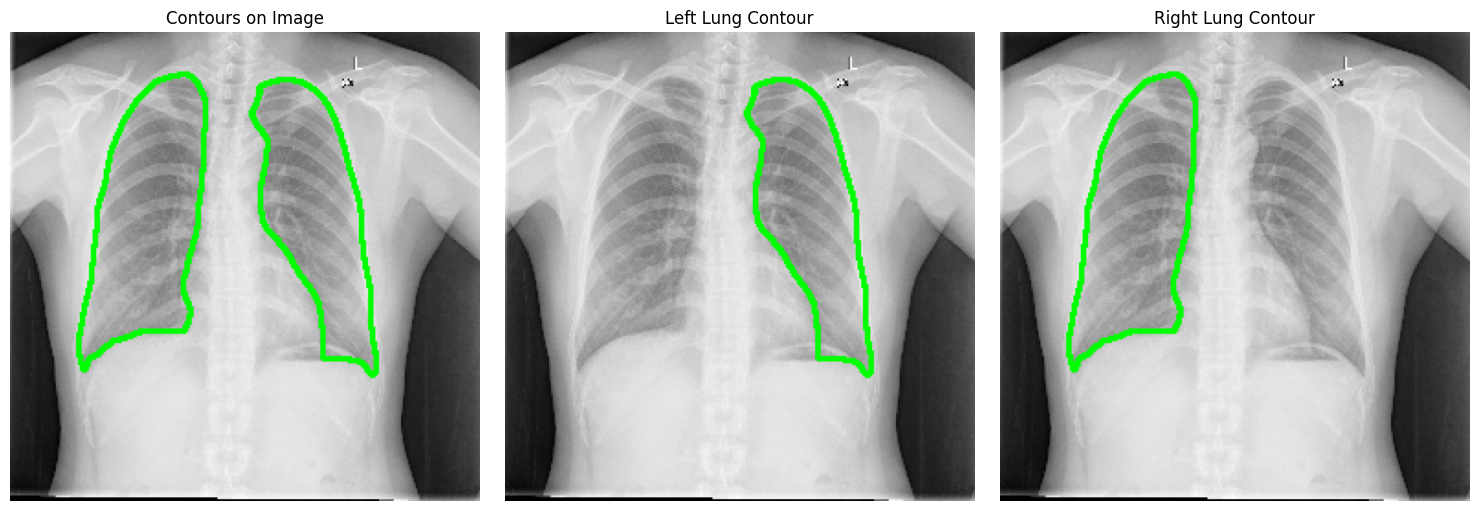

In [ ]:
# 데이터 처리 루프 이후에 추가
import matplotlib.pyplot as plt
import random

def visualize_contours(index):
    plt.figure(figsize=(15,5))

    # 원본 이미지에 모든 contour 표시
    img_all = X_all[index].copy()
    lung_mask = (y_all[index,:,:,1] + y_all[index,:,:,2]).astype(np.uint8)
    contours, _ = cv2.findContours(lung_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    plt.subplot(131)
    img_with_contours = X_all[index].copy()
    cv2.drawContours(img_with_contours, contours, -1, (0,255,0), 2)
    plt.imshow(img_with_contours)
    plt.title('Contours on Image')
    plt.axis('off')

    # 좌측 폐 contour
    plt.subplot(132)
    left_img = X_all[index].copy()
    left_mask = y_all[index,:,:,1].astype(np.uint8)
    left_contours, _ = cv2.findContours(left_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(left_img, left_contours, -1, (0,255,0), 2)
    plt.imshow(left_img)
    plt.title('Left Lung Contour')
    plt.axis('off')

    # 우측 폐 contour
    plt.subplot(133)
    right_img = X_all[index].copy()
    right_mask = y_all[index,:,:,2].astype(np.uint8)
    right_contours, _ = cv2.findContours(right_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(right_img, right_contours, -1, (0,255,0), 2)
    plt.imshow(right_img)
    plt.title('Right Lung Contour')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# 랜덤으로 5개 이미지 선택하여 결과 확인
print("\n=== Random Sample Contour Results ===")
random_indices = random.sample(range(len(X_all)), 5)
for idx in random_indices:
    print(f"\nImage {idx}")
    visualize_contours(idx)

In [ ]:
X_all = X_all.astype('float32') / 255 #정규화

In [ ]:
X_all.shape
y_all.shape

(566, 256, 256, 3)

In [ ]:
seed = 7 #코드를 여러 번 실행해도 결과가 동일하게 출력되기 위해서 사용
np.random.seed(seed)

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

In [ ]:
print('X_train',X_train.shape)
print('X_valid',X_valid.shape)
print('X_test',X_test.shape)
print('y_train',y_train.shape)
print('y_valid',y_valid.shape)
print('y_test',y_test.shape)

X_train (361, 256, 256, 3)
X_valid (91, 256, 256, 3)
X_test (114, 256, 256, 3)
y_train (361, 256, 256, 3)
y_valid (91, 256, 256, 3)
y_test (114, 256, 256, 3)


모델 설계 및 학습 (2D U-Net)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import Add
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model

In [ ]:
#의료 이미지 분할을 목적으로 2D U-net 모델을 도입

from tensorflow.keras.layers import Concatenate

def unet(input_size=(256,256,3)):
    inputs = Input(input_size)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs) #256X256X3 -> 256X256X32 (32개의 3X3 필터가 연산 수행)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPool2D(pool_size=(2, 2))(conv1) #256X256X32 -> 128X128X32

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #128X128X32 -> 128X128X64
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPool2D(pool_size=(2, 2))(conv2) #128X128X64 -> 64X64X64

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #64X64X64 -> 64X64X128
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPool2D(pool_size=(2, 2))(conv3) #64X64X128 -> 32X32X128

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3) #32X32X128 -> 32X32X256
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPool2D(pool_size=(2, 2))(conv4) #32X32X256 -> 16X16X256

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4) #16X16X256 -> 16X16X512
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5) #16X16X512

#conv1 - conv5까지는 Encoder (Contracting path)이다.
#이 부분에서는 이미지의 크기가 점차 감소(maxpooling)하며 필터 수는 증가한다
#conv1에서는 보통 간단한 특징들을, 5로 갈수록 복잡한 특징(전체 구조) 등을 추출한다

    up6 = Concatenate()([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4]) #16X16X512 -> 32X32X256
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = BatchNormalization()(conv6) #32X32X512
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6) #32X32X256

    up7 = Concatenate()([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3]) #32X32X256 -> 64X64X128
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = BatchNormalization()(conv7) #64X64X256
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7) #64X64X128

    up8 = Concatenate()([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2]) #64X64X128 -> 128X128X64
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = BatchNormalization()(conv8) #128X128X128
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8) #128X128X64

    up9 = Concatenate()([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1]) #128X128X64 -> 256X256X32
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = BatchNormalization()(conv9) #256X256X64
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
    conv9 = BatchNormalization()(conv9) #256X256X32

#conv6-conv9 까지는 Decoder (Expanding path)이다
#이 부분은 이미지가 점차 확장되면서 원래 크기로 복원된다
#Concatenate 부분은 skip-connection으로 encoder와 같은 레벨의 특징과 결합 (1-9 2-8 3-7 4-6)


    conv10 = Conv2D(3, (1, 1), activation='softmax')(conv9) #최종 출력층, channels = 3 (배경, 왼쪽, 오른쪽)

    #다중 클래스 분류를 위해 활성화함수를 softmax로 하였다.
    #softmax는 각 픽셀 위치에서 세 클래스의 확률값의 합이 1이 되도록 한다 (각 픽셀이 어느 클래스인지 확률값으로)

    return Model(inputs=[inputs], outputs=[conv10])

모델 컴파일

In [ ]:
import tensorflow as tf

def dice_coef(y_true,y_pred,smooth=1.0): #평가지표로는 Dice Coefficient를 사용하였다.
    #segmentation에서 예측된 영역과 실제 영역의 겹치는 정도를 측정
    intersection = tf.reduce_sum(y_true * y_pred, axis = [1,2]) #교집합 계산 (axis =[1,2]는 높이와 너비 방향으로 합계 계산)
    union = tf.reduce_sum(y_true, axis = [1,2]) + tf.reduce_sum(y_pred, axis = [1,2]) #합집합 계산

    #각 클래스별 dice coefficient 계산
    dice = (2 * intersection + smooth) / (union + smooth) #공식 구현
    #모든 클래스에 대해 평균 계산
    return tf.reduce_mean(dice)

def dice_coef_loss(y_true,y_pred):
    return 1 - dice_coef(y_true,y_pred) #Dice loss는 1에서 Dice Coefficient를 뺀 값으로 손실함수로써 정의

In [ ]:
#모델 컴파일
model = unet()
model.compile(
    optimizer = 'adam',
    loss=dice_coef_loss,
    metrics=[dice_coef,'accuracy']
)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 256, 256, 3))
  warnings.warn(msg)


46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step - accuracy: 0.7698 - dice_coef: 0.6547 - loss: 0.3454
Epoch 1: val_dice_coef improved from -inf to 0.45425, saving model to lung_segmentation_model.h5


46/46 ━━━━━━━━━━━━━━━━━━━━ 73s 745ms/step - accuracy: 0.7725 - dice_coef: 0.6581 - loss: 0.3420 - val_accuracy: 0.6490 - val_dice_coef: 0.4542 - val_loss: 0.5470
Epoch 2/100
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.9714 - dice_coef: 0.9438 - loss: 0.0562
Epoch 2: val_dice_coef did not improve from 0.45425
46/46 ━━━━━━━━━━━━━━━━━━━━ 29s 170ms/step - accuracy: 0.9714 - dice_coef: 0.9438 - loss: 0.0562 - val_accuracy: 0.7598 - val_dice_coef: 0.3556 - val_loss: 0.6439
Epoch 3/100
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.9735 - dice_coef: 0.9532 - loss: 0.0468
Epoch 3: val_dice_coef improved from 0.45425 to 0.51871, saving model to lung_segmentation_model.h5


46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 183ms/step - accuracy: 0.9736 - dice_coef: 0.9534 - loss: 0.0466 - val_accuracy: 0.8107 - val_dice_coef: 0.5187 - val_loss: 0.4806
Epoch 4/100
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.9763 - dice_coef: 0.9601 - loss: 0.0399
Epoch 4: val_dice_coef improved from 0.51871 to 0.57887, saving model to lung_segmentation_model.h5


46/46 ━━━━━━━━━━━━━━━━━━━━ 10s 183ms/step - accuracy: 0.9764 - dice_coef: 0.9602 - loss: 0.0398 - val_accuracy: 0.7552 - val_dice_coef: 0.5789 - val_loss: 0.4218
Epoch 5/100
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.9772 - dice_coef: 0.9621 - loss: 0.0379
Epoch 5: val_dice_coef improved from 0.57887 to 0.62184, saving model to lung_segmentation_model.h5


46/46 ━━━━━━━━━━━━━━━━━━━━ 9s 187ms/step - accuracy: 0.9772 - dice_coef: 0.9622 - loss: 0.0378 - val_accuracy: 0.7635 - val_dice_coef: 0.6218 - val_loss: 0.3788
Epoch 6/100
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.9768 - dice_coef: 0.9619 - loss: 0.0381
Epoch 6: val_dice_coef did not improve from 0.62184
46/46 ━━━━━━━━━━━━━━━━━━━━ 8s 174ms/step - accuracy: 0.9769 - dice_coef: 0.9619 - loss: 0.0381 - val_accuracy: 0.7930 - val_dice_coef: 0.5169 - val_loss: 0.4818
Epoch 7/100
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.9782 - dice_coef: 0.9648 - loss: 0.0352
Epoch 7: val_dice_coef improved from 0.62184 to 0.64728, saving model to lung_segmentation_model.h5


46/46 ━━━━━━━━━━━━━━━━━━━━ 9s 186ms/step - accuracy: 0.9783 - dice_coef: 0.9649 - loss: 0.0351 - val_accuracy: 0.8401 - val_dice_coef: 0.6473 - val_loss: 0.3508
Epoch 8/100
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.9785 - dice_coef: 0.9654 - loss: 0.0346
Epoch 8: val_dice_coef improved from 0.64728 to 0.64862, saving model to lung_segmentation_model.h5


46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 191ms/step - accuracy: 0.9785 - dice_coef: 0.9655 - loss: 0.0345 - val_accuracy: 0.8546 - val_dice_coef: 0.6486 - val_loss: 0.3513
Epoch 9/100
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.9791 - dice_coef: 0.9666 - loss: 0.0334
Epoch 9: val_dice_coef improved from 0.64862 to 0.86221, saving model to lung_segmentation_model.h5


46/46 ━━━━━━━━━━━━━━━━━━━━ 10s 189ms/step - accuracy: 0.9791 - dice_coef: 0.9666 - loss: 0.0334 - val_accuracy: 0.9247 - val_dice_coef: 0.8622 - val_loss: 0.1388
Epoch 10/100
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.9791 - dice_coef: 0.9665 - loss: 0.0335
Epoch 10: val_dice_coef improved from 0.86221 to 0.95633, saving model to lung_segmentation_model.h5


46/46 ━━━━━━━━━━━━━━━━━━━━ 9s 191ms/step - accuracy: 0.9791 - dice_coef: 0.9665 - loss: 0.0335 - val_accuracy: 0.9732 - val_dice_coef: 0.9563 - val_loss: 0.0436
Epoch 11/100
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.9794 - dice_coef: 0.9671 - loss: 0.0329
Epoch 11: val_dice_coef did not improve from 0.95633
46/46 ━━━━━━━━━━━━━━━━━━━━ 8s 181ms/step - accuracy: 0.9794 - dice_coef: 0.9672 - loss: 0.0328 - val_accuracy: 0.9683 - val_dice_coef: 0.9478 - val_loss: 0.0526
Epoch 12/100
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.9794 - dice_coef: 0.9673 - loss: 0.0327
Epoch 12: val_dice_coef improved from 0.95633 to 0.96251, saving model to lung_segmentation_model.h5


46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 191ms/step - accuracy: 0.9795 - dice_coef: 0.9674 - loss: 0.0326 - val_accuracy: 0.9765 - val_dice_coef: 0.9625 - val_loss: 0.0376
Epoch 13/100
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.9794 - dice_coef: 0.9672 - loss: 0.0328
Epoch 13: val_dice_coef did not improve from 0.96251
46/46 ━━━━━━━━━━━━━━━━━━━━ 10s 177ms/step - accuracy: 0.9794 - dice_coef: 0.9671 - loss: 0.0329 - val_accuracy: 0.8000 - val_dice_coef: 0.4950 - val_loss: 0.5044
Epoch 14/100
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.9722 - dice_coef: 0.9552 - loss: 0.0448
Epoch 14: val_dice_coef did not improve from 0.96251
46/46 ━━━━━━━━━━━━━━━━━━━━ 10s 177ms/step - accuracy: 0.9723 - dice_coef: 0.9553 - loss: 0.0447 - val_accuracy: 0.7648 - val_dice_coef: 0.6114 - val_loss: 0.3874
Epoch 15/100
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.9777 - dice_coef: 0.9644 - loss: 0.0356
Epoch 15: val_dice_coef did not improve from 0.96251
46/46 ━━━━━━━━━━━━━━━━━━━━ 8s 1

46/46 ━━━━━━━━━━━━━━━━━━━━ 9s 189ms/step - accuracy: 0.9796 - dice_coef: 0.9677 - loss: 0.0323 - val_accuracy: 0.9768 - val_dice_coef: 0.9632 - val_loss: 0.0365
Epoch 18/100
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.9798 - dice_coef: 0.9680 - loss: 0.0320
Epoch 18: val_dice_coef did not improve from 0.96323
46/46 ━━━━━━━━━━━━━━━━━━━━ 10s 181ms/step - accuracy: 0.9798 - dice_coef: 0.9681 - loss: 0.0319 - val_accuracy: 0.9706 - val_dice_coef: 0.9532 - val_loss: 0.0461
Epoch 19/100
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.9798 - dice_coef: 0.9682 - loss: 0.0318
Epoch 19: val_dice_coef did not improve from 0.96323
46/46 ━━━━━━━━━━━━━━━━━━━━ 10s 178ms/step - accuracy: 0.9799 - dice_coef: 0.9682 - loss: 0.0318 - val_accuracy: 0.9762 - val_dice_coef: 0.9625 - val_loss: 0.0376
Epoch 20/100
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.9800 - dice_coef: 0.9684 - loss: 0.0316
Epoch 20: val_dice_coef did not improve from 0.96323
46/46 ━━━━━━━━━━━━━━━━━━━━ 10s 1

46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 189ms/step - accuracy: 0.9803 - dice_coef: 0.9689 - loss: 0.0311 - val_accuracy: 0.9789 - val_dice_coef: 0.9663 - val_loss: 0.0337
Epoch 25/100
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.9800 - dice_coef: 0.9686 - loss: 0.0314
Epoch 25: val_dice_coef did not improve from 0.96634
46/46 ━━━━━━━━━━━━━━━━━━━━ 10s 179ms/step - accuracy: 0.9801 - dice_coef: 0.9686 - loss: 0.0314 - val_accuracy: 0.9707 - val_dice_coef: 0.9525 - val_loss: 0.0476
Epoch 26/100
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.9805 - dice_coef: 0.9694 - loss: 0.0306
Epoch 26: val_dice_coef did not improve from 0.96634
46/46 ━━━━━━━━━━━━━━━━━━━━ 10s 177ms/step - accuracy: 0.9806 - dice_coef: 0.9695 - loss: 0.0305 - val_accuracy: 0.9768 - val_dice_coef: 0.9626 - val_loss: 0.0376
Epoch 27/100
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.9808 - dice_coef: 0.9698 - loss: 0.0302
Epoch 27: val_dice_coef did not improve from 0.96634
46/46 ━━━━━━━━━━━━━━━━━━━━ 10s 

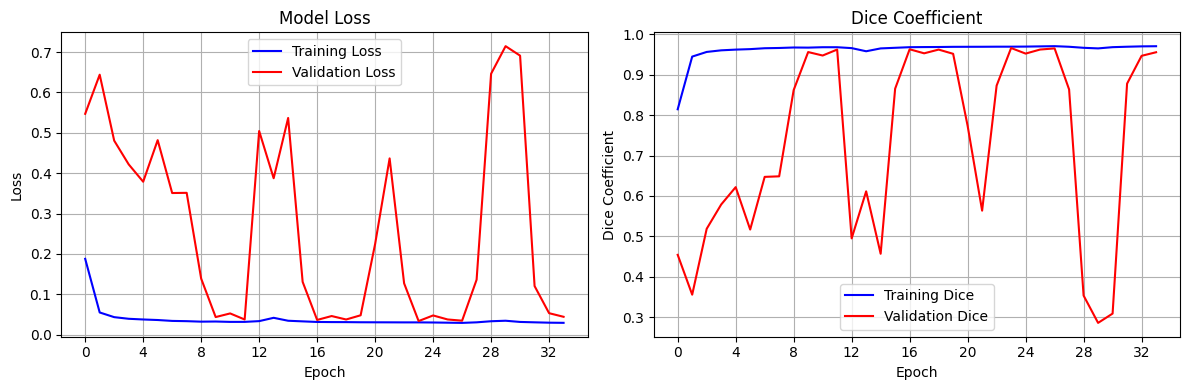

In [ ]:
#재현성을 위한 시드 설정
seed = 7
np.random.seed(seed)
tf.random.set_seed(seed)

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

optimizer = Adam(learning_rate = 1e-4)

#체크포인트만 정의
from tensorflow.keras.callbacks import ModelCheckpoint

callbacks = [
    EarlyStopping(
        monitor='val_dice_coef', #검증 세트의 dice coefficient 모니터링
        mode='max', #dice coefficient는 높을 수록 좋음
        patience=10, #10에폭동안 개선이 없다면 학습을 중단
        restore_best_weights = True, #최적의 가중치 복원
        verbose=1
    ),

    ModelCheckpoint(
        'lung_segmentation_model.h5',
        monitor='val_dice_coef',
        mode='max',
        save_best_only=True,
        verbose=1
    )
]


#모델 학습
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_valid,y_valid),
    batch_size=8,
    epochs=100,
    callbacks=callbacks,
    verbose=1
)

# 테스트 데이터에 대한 평가
test_results = model.evaluate(X_test, y_test, verbose=0)

# 최종 성능 출력
print("\n=== Final Model Performance ===")
print(f"Training Loss: {history.history['loss'][-1]:.4f}")
print(f"Training Dice Coefficient: {history.history['dice_coef'][-1]:.4f}")
print(f"Validation Loss: {history.history['val_loss'][-1]:.4f}")
print(f"Validation Dice Coefficient: {history.history['val_dice_coef'][-1]:.4f}")
print(f"Test Loss: {test_results[0]:.4f}")
print(f"Test Dice Coefficient: {test_results[1]:.4f}")

#학습 과정 시각화
plt.figure(figsize=(12,4))

#loss 그래프
plt.subplot(1,2,1)
plt.plot(history.history['loss'], 'b-', label='Training Loss')
plt.plot(history.history['val_loss'],'r-', label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.xticks(range(0, len(history.history['loss']), 4))


#Dice coefficient 그래프
plt.subplot(1,2,2)
plt.plot(history.history['dice_coef'],'b-', label='Training Dice')
plt.plot(history.history['val_dice_coef'],'r-', label='Validation Dice')
plt.title('Dice Coefficient')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.grid(True)
plt.xticks(range(0, len(history.history['dice_coef']), 4))


plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 256, 256, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Training Dice Coefficient: 0.9824


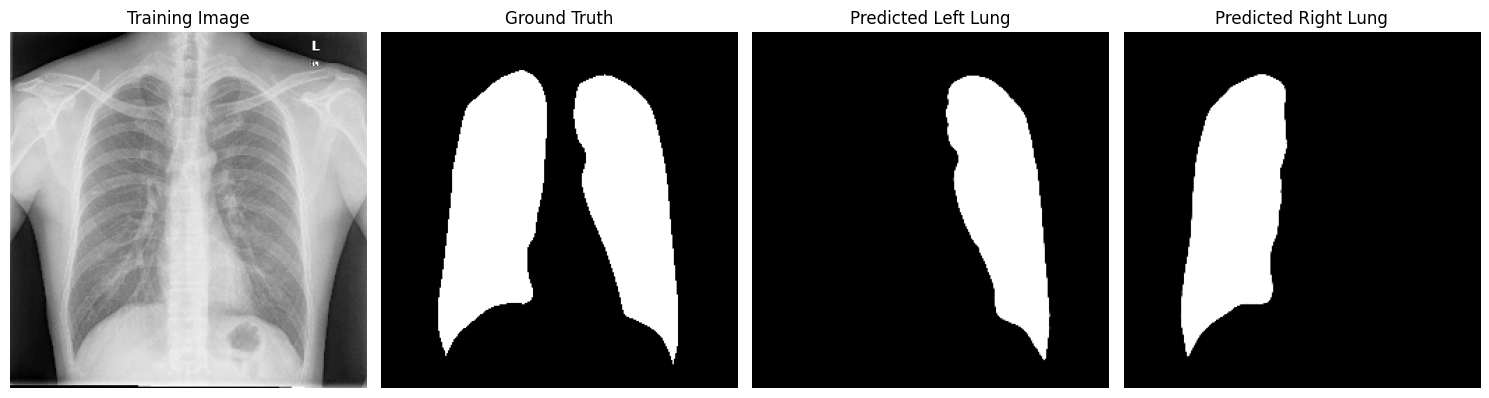

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Validation Dice Coefficient: 0.9858


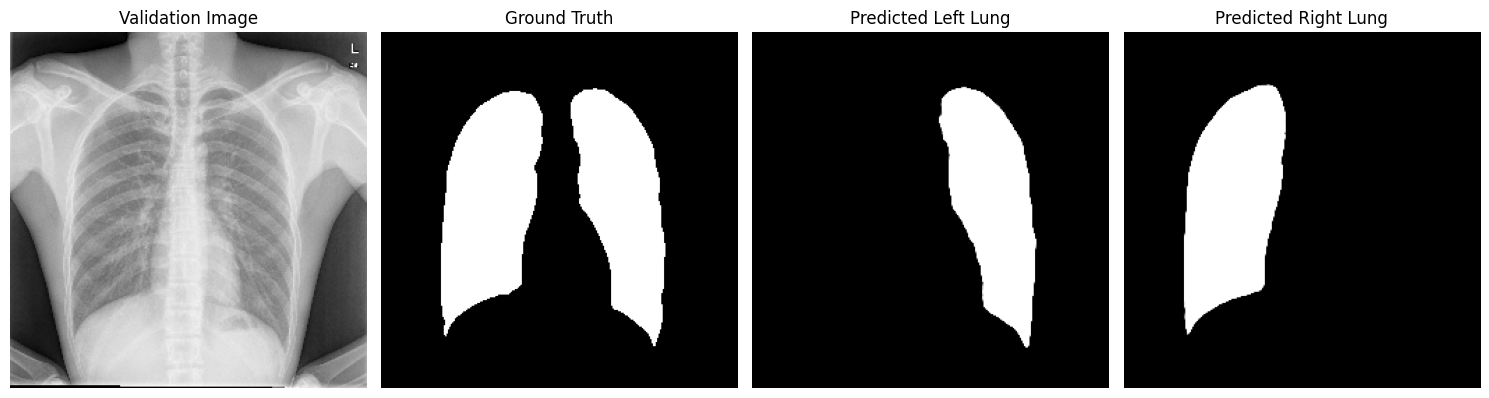

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Test Dice Coefficient: 0.9807


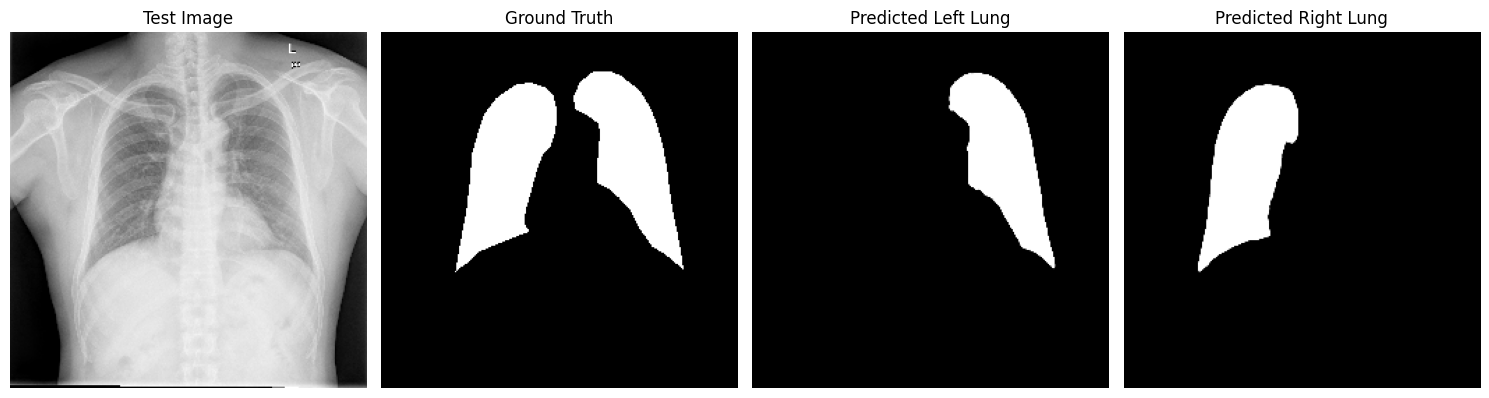

In [ ]:
import matplotlib.pyplot as plt

def plotPredictions(X_train_, y_train_, X_valid_, y_valid_, X_test_, y_test_, model):
    def plot_sample(X,y,pred,title_prefix):
        plt.figure(figsize=(15,5))

        #원본 이미지
        plt.subplot(1,4,1)
        plt.title(f"{title_prefix} Image")
        plt.imshow(X[0])
        plt.axis('off')

        #실제 마스크 (전체 폐)
        plt.subplot(1,4,2)
        plt.title("Ground Truth")

        #왼쪽 오른쪽 폐를 동시에 표시
        plt.imshow(y[0,:,:,1]+y[0,:,:,2], 'gray')
        plt.axis('off')

        #예측 마스크 (왼쪽 폐)
        plt.subplot(1,4,3)
        plt.title("Predicted Left Lung")
        plt.imshow(pred[0,:,:,1], 'gray')
        plt.axis('off')

        #예측 마스크 (오른쪽 폐)
        plt.subplot(1,4,4)
        plt.title("Predicted Right Lung")
        plt.imshow(pred[0,:,:,2],'gray')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

    #학습 데이터에서 랜덤 샘플 예측
    ix = np.random.randint(0, len(X_train_))
    input_ = X_train_[ix:ix+1]
    mask_ = y_train_[ix:ix+1]
    preds_train = model.predict(input_)
    ret = model.evaluate(input_, mask_,verbose=0)
    print(f"Training Dice Coefficient: {ret[1]:.4f}")
    plot_sample(input_, mask_, preds_train, "Training")

    #검증 데이터에서 랜덤 샘플 예측
    ix = np.random.randint(0, len(X_valid_))
    input_ = X_valid_[ix:ix+1]
    mask_ = y_valid_[ix:ix+1]
    preds_valid = model.predict(input_)
    ret=model.evaluate(input_, mask_,verbose=0)
    print(f"Validation Dice Coefficient: {ret[1]:.4f}")
    plot_sample(input_, mask_, preds_valid, "Validation")

    #테스트 데이터에서 랜덤 샘플 예측
    ix = np.random.randint(0, len(X_test_))
    input_ = X_test_[ix:ix+1]
    mask_ = y_test_[ix:ix+1]
    preds_test = model.predict(input_)
    ret=model.evaluate(input_, mask_,verbose=0)
    print(f"Test Dice Coefficient: {ret[1]:.4f}")
    plot_sample(input_, mask_, preds_test, "Test")

#모델 예측 결과 시각화
plotPredictions(X_train, y_train, X_valid, y_valid, X_test, y_test, model)

Training Data Predictions:
Training Sample 1 Dice Coefficient: 0.9414


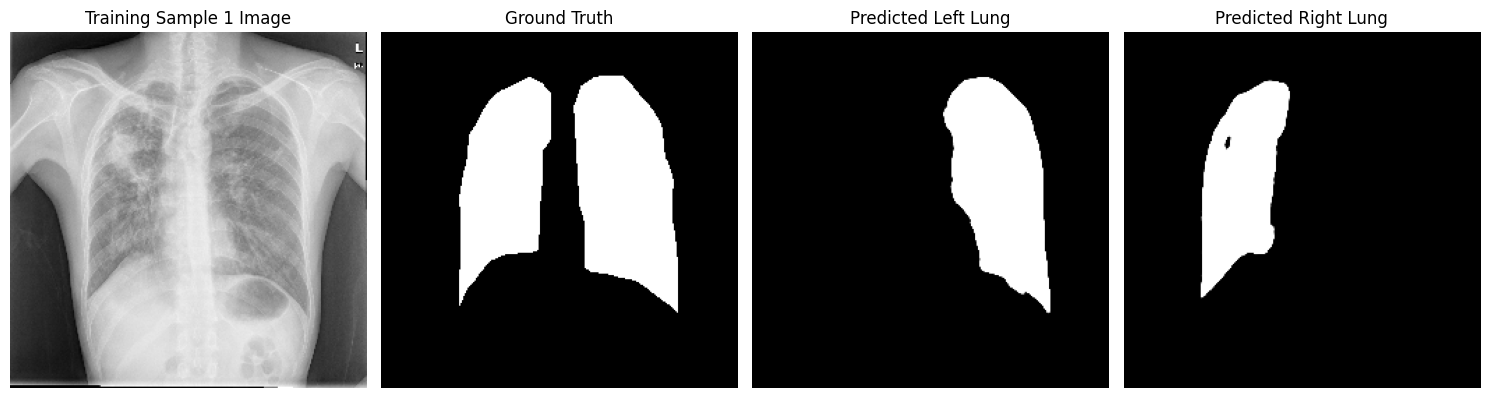

Training Sample 2 Dice Coefficient: 0.9727


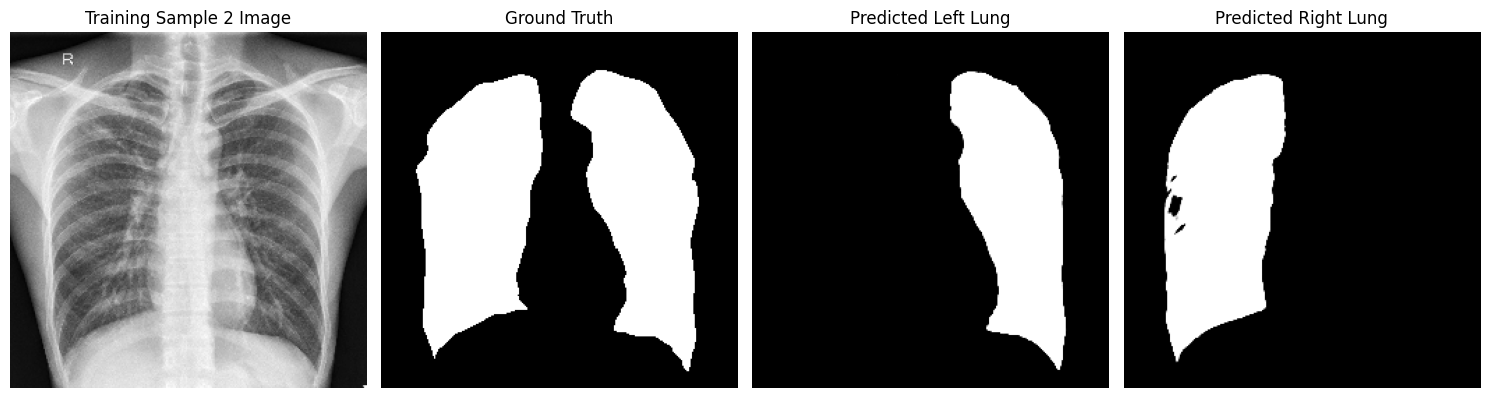

Training Sample 3 Dice Coefficient: 0.9745


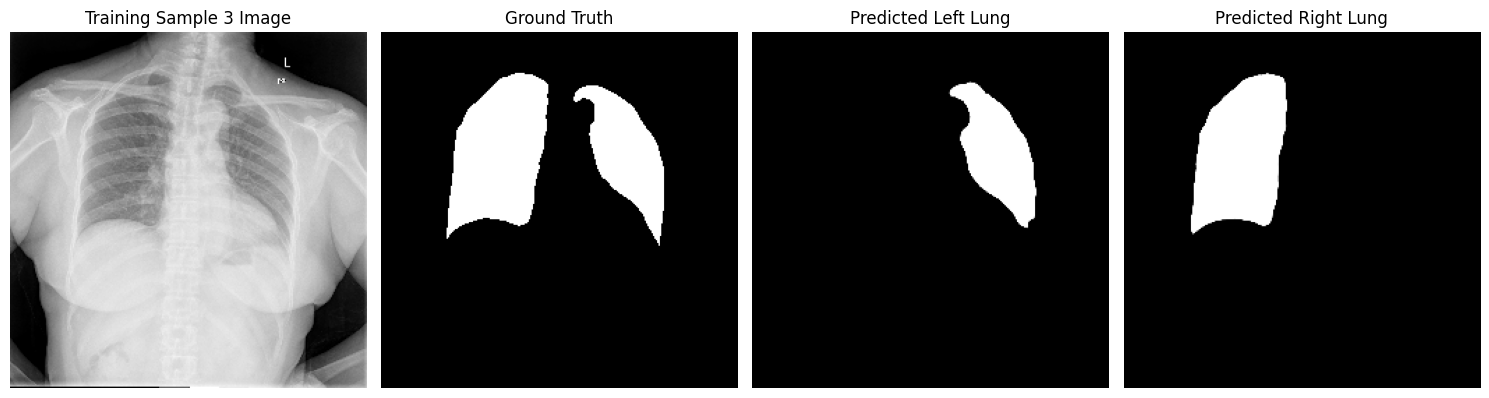


Validation Data Predictions:
Validation Sample 1 Dice Coefficient: 0.9824


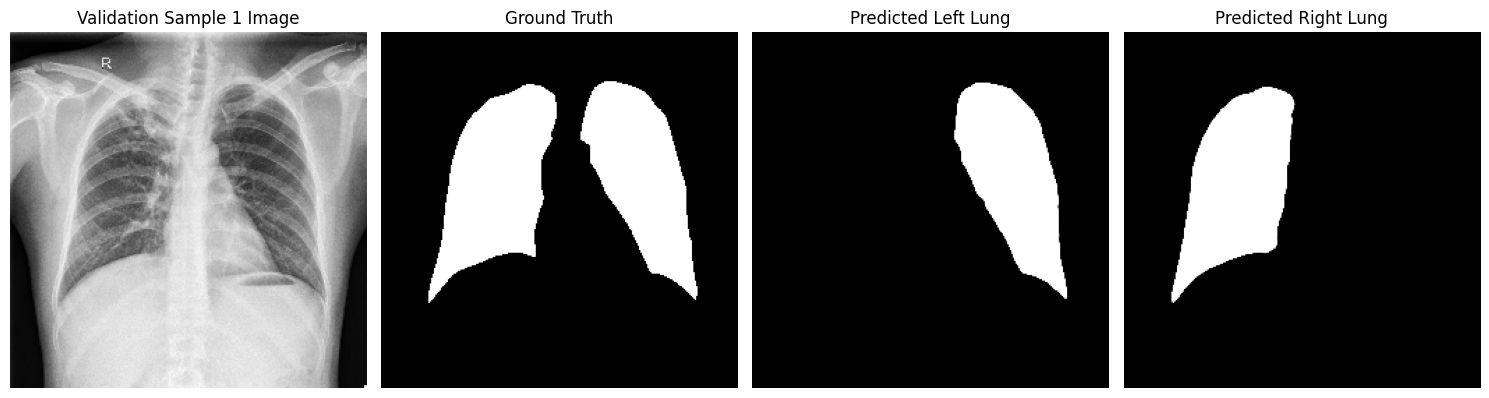

Validation Sample 2 Dice Coefficient: 0.9753


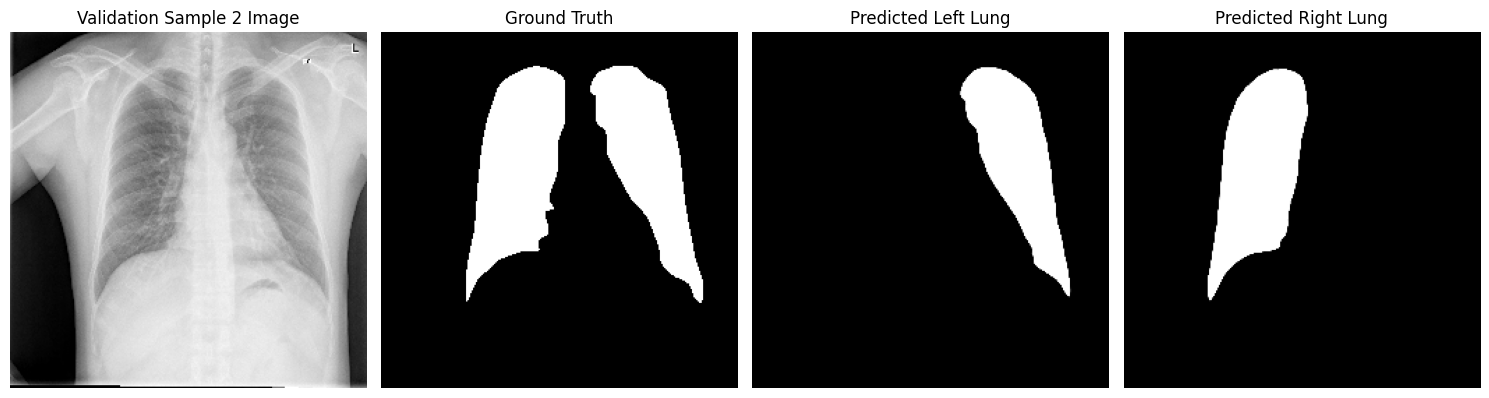

Validation Sample 3 Dice Coefficient: 0.9811


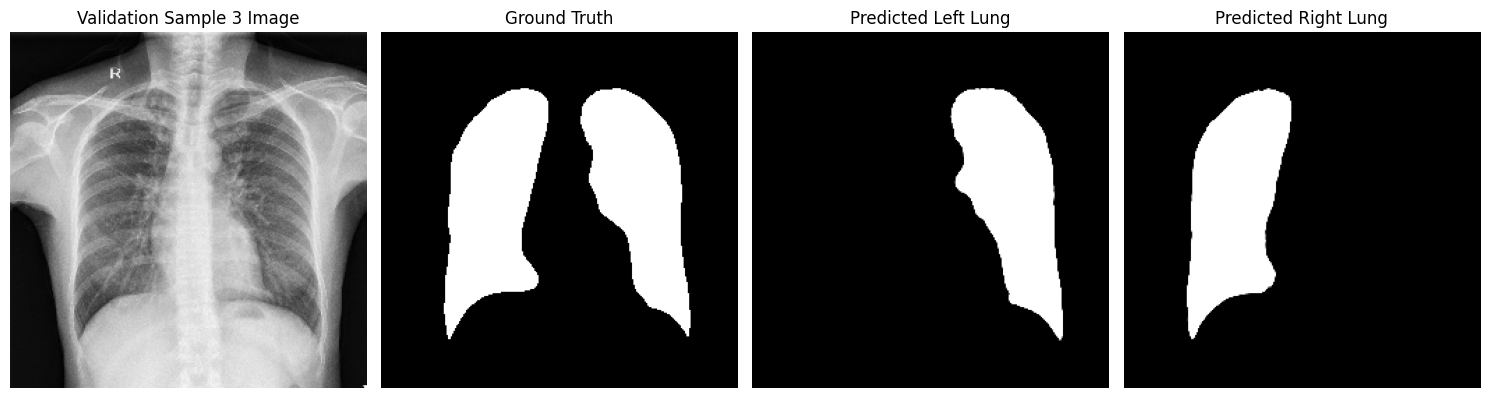


Test Data Predictions:
Test Sample 1 Dice Coefficient: 0.9771


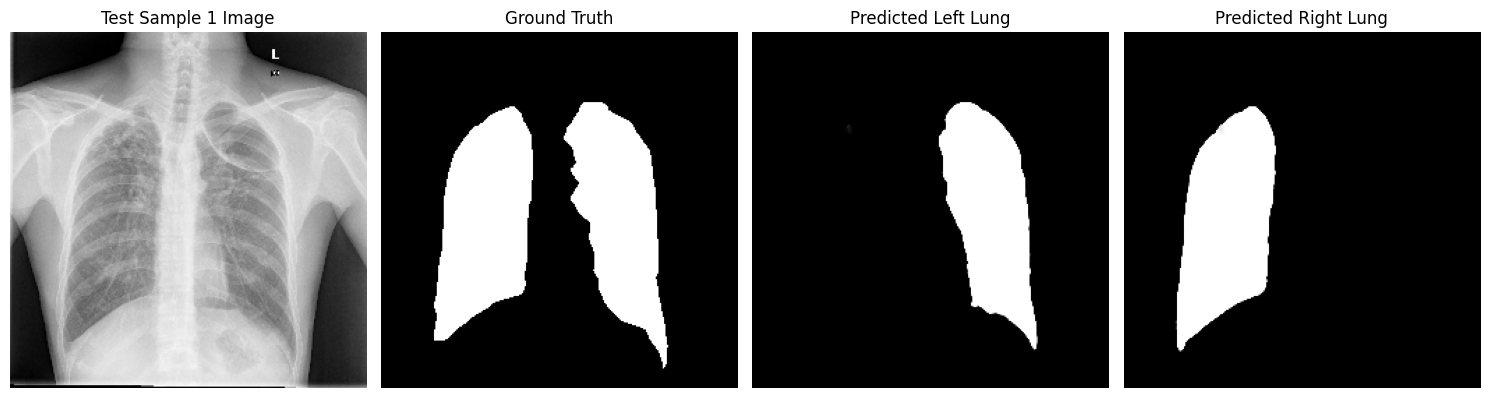

Test Sample 2 Dice Coefficient: 0.9803


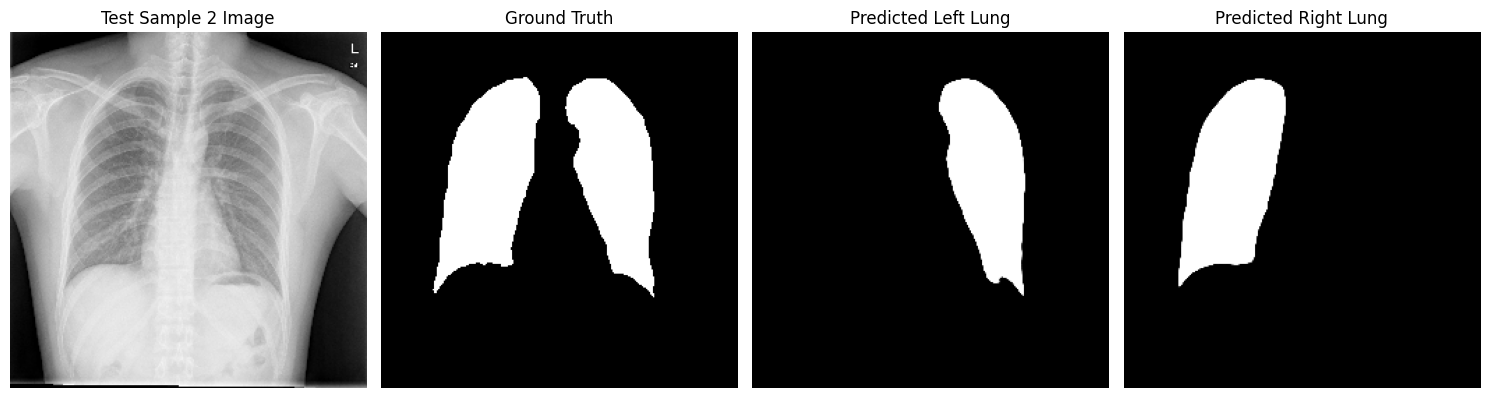

Test Sample 3 Dice Coefficient: 0.9837


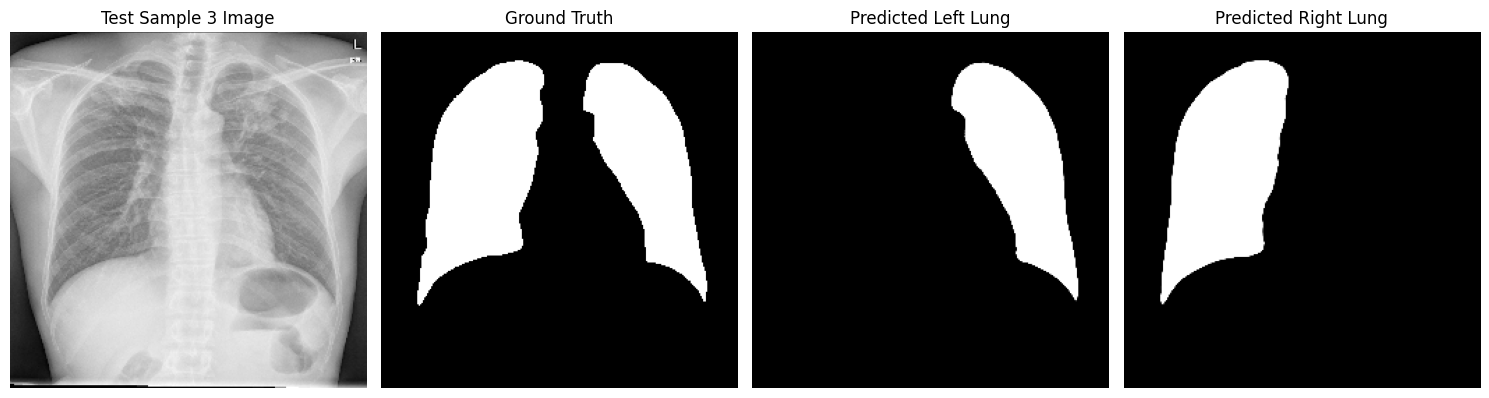

In [ ]:
import matplotlib.pyplot as plt

def plotPredictions(X_train_, y_train_, X_valid_, y_valid_, X_test_, y_test_, model):
    def plot_sample(X,y,pred,title_prefix):
        plt.figure(figsize=(15,5))

        #원본 이미지
        plt.subplot(1,4,1)
        plt.title(f"{title_prefix} Image")
        plt.imshow(X[0])
        plt.axis('off')

        #실제 마스크 (전체 폐)
        plt.subplot(1,4,2)
        plt.title("Ground Truth")

        #왼쪽 오른쪽 폐를 동시에 표시
        plt.imshow(y[0,:,:,1]+y[0,:,:,2], 'gray')
        plt.axis('off')

        #예측 마스크 (왼쪽 폐)
        plt.subplot(1,4,3)
        plt.title("Predicted Left Lung")
        plt.imshow(pred[0,:,:,1], 'gray')
        plt.axis('off')

        #예측 마스크 (오른쪽 폐)
        plt.subplot(1,4,4)
        plt.title("Predicted Right Lung")
        plt.imshow(pred[0,:,:,2],'gray')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

    # 학습 데이터에서 3개 랜덤 샘플 예측
    print("Training Data Predictions:")
    for i in range(3):
        ix = np.random.randint(0, len(X_train_))
        input_ = X_train_[ix:ix+1]
        mask_ = y_train_[ix:ix+1]
        preds_train = model.predict(input_, verbose=0)
        ret = model.evaluate(input_, mask_,verbose=0)
        print(f"Training Sample {i+1} Dice Coefficient: {ret[1]:.4f}")
        plot_sample(input_, mask_, preds_train, f"Training Sample {i+1}")

    # 검증 데이터에서 3개 랜덤 샘플 예측
    print("\nValidation Data Predictions:")
    for i in range(3):
        ix = np.random.randint(0, len(X_valid_))
        input_ = X_valid_[ix:ix+1]
        mask_ = y_valid_[ix:ix+1]
        preds_valid = model.predict(input_, verbose=0)
        ret = model.evaluate(input_, mask_,verbose=0)
        print(f"Validation Sample {i+1} Dice Coefficient: {ret[1]:.4f}")
        plot_sample(input_, mask_, preds_valid, f"Validation Sample {i+1}")

    # 테스트 데이터에서 3개 랜덤 샘플 예측
    print("\nTest Data Predictions:")
    for i in range(3):
        ix = np.random.randint(0, len(X_test_))
        input_ = X_test_[ix:ix+1]
        mask_ = y_test_[ix:ix+1]
        preds_test = model.predict(input_, verbose=0)
        ret = model.evaluate(input_, mask_,verbose=0)
        print(f"Test Sample {i+1} Dice Coefficient: {ret[1]:.4f}")
        plot_sample(input_, mask_, preds_test, f"Test Sample {i+1}")

# 모델 예측 결과 시각화
plotPredictions(X_train, y_train, X_valid, y_valid, X_test, y_test, model)

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 402ms/step
=== Worst 5 Cases ===


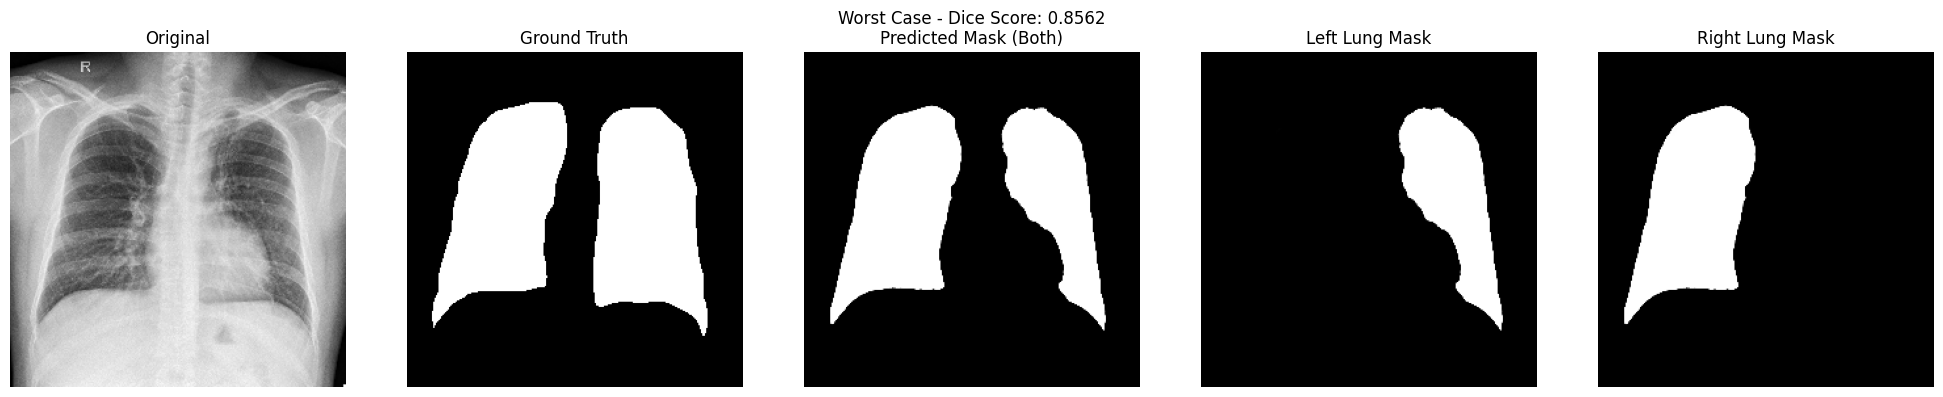

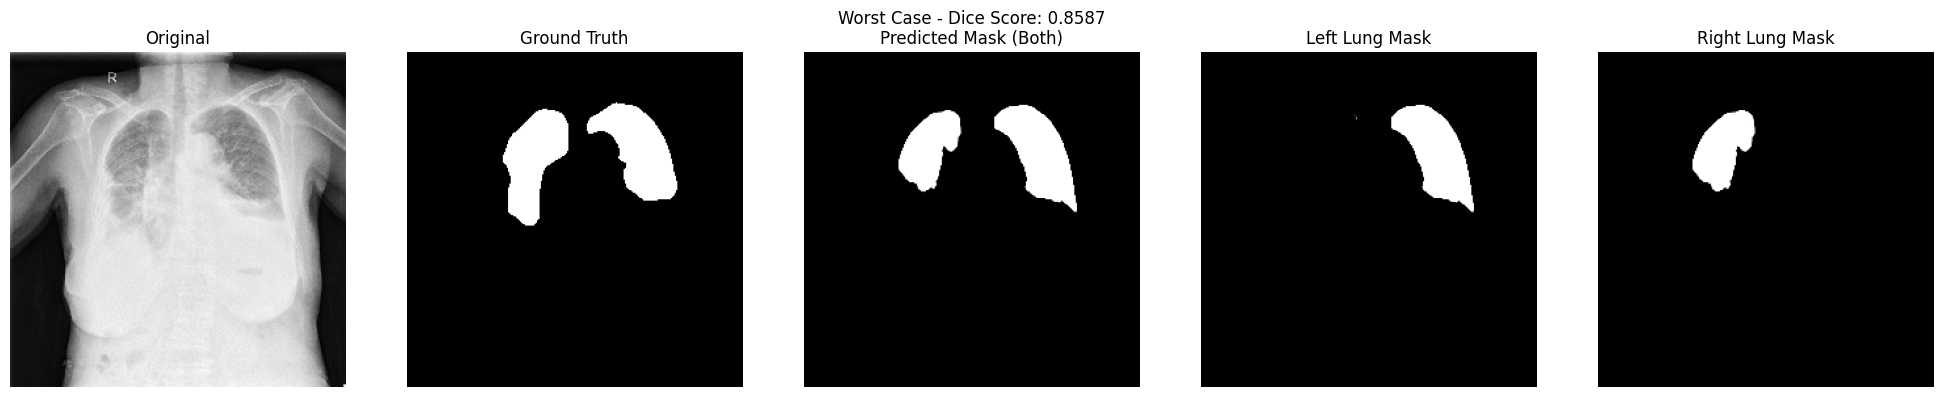

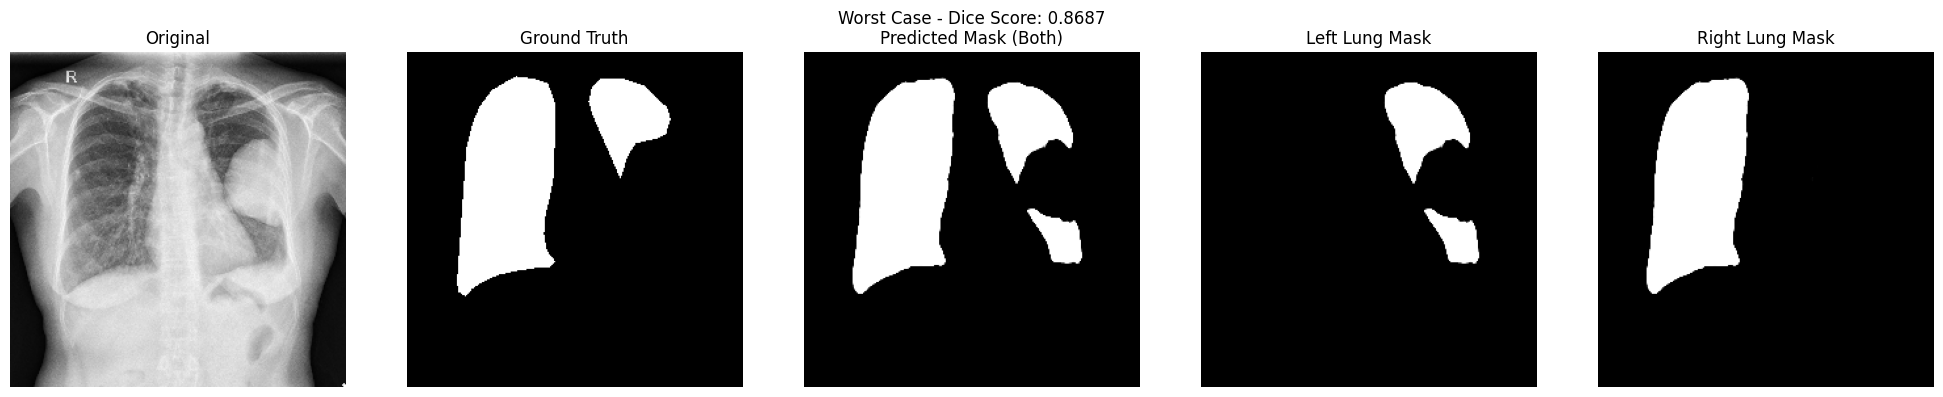

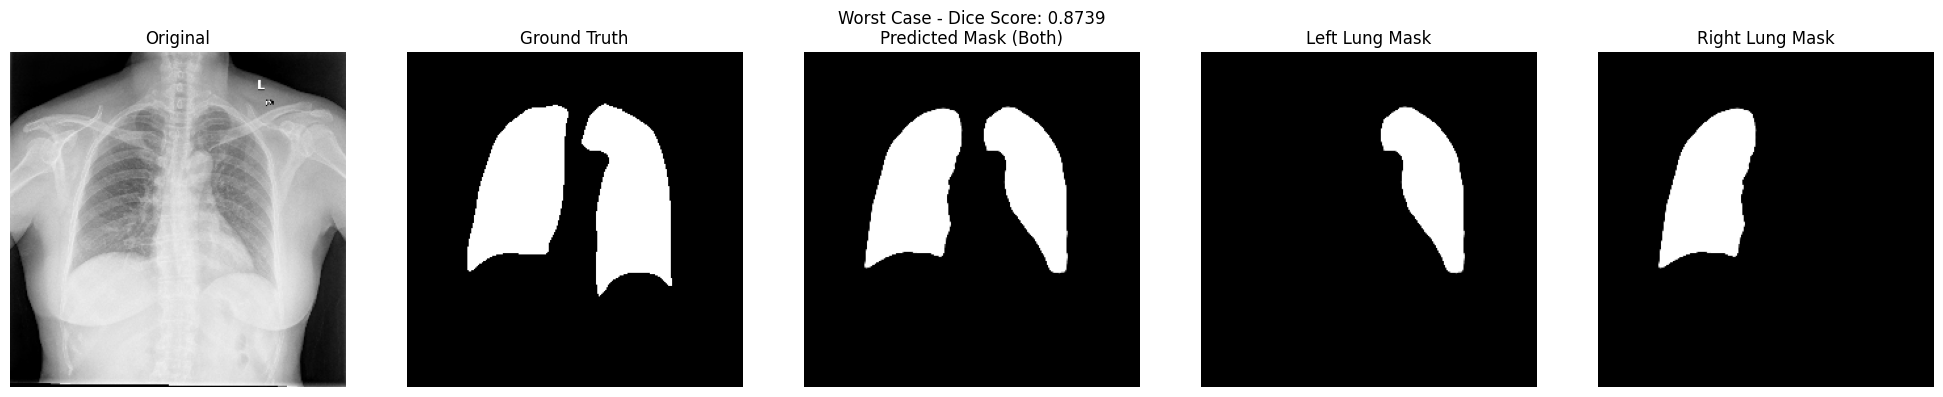

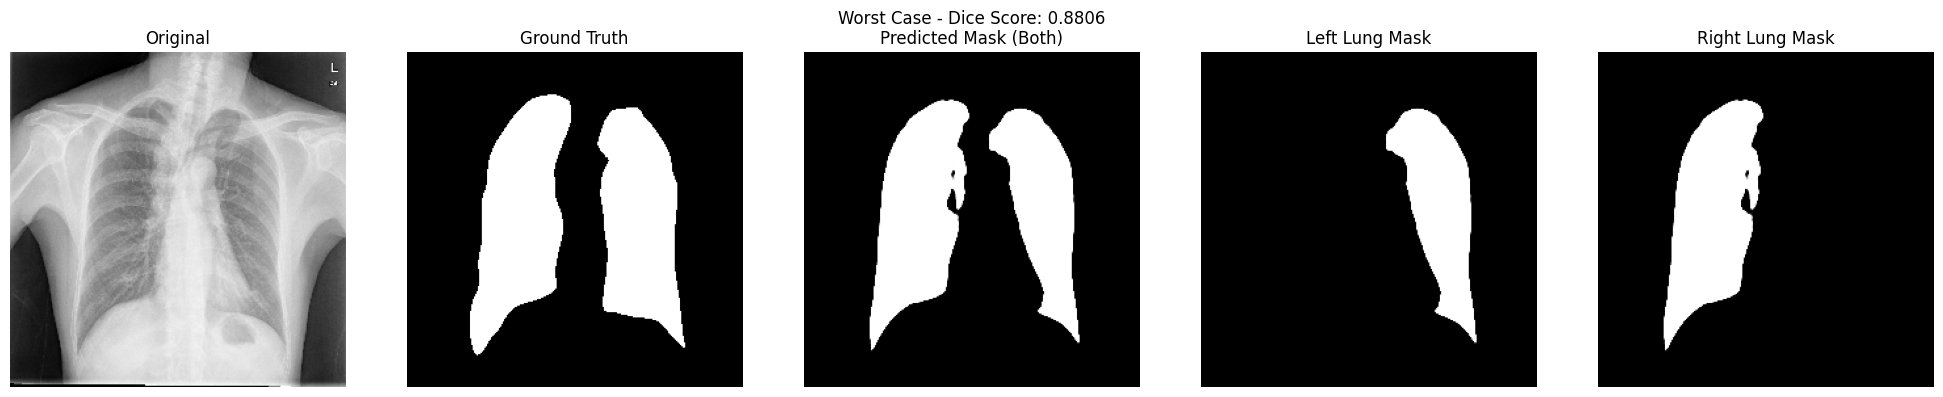


=== Best 5 Cases ===


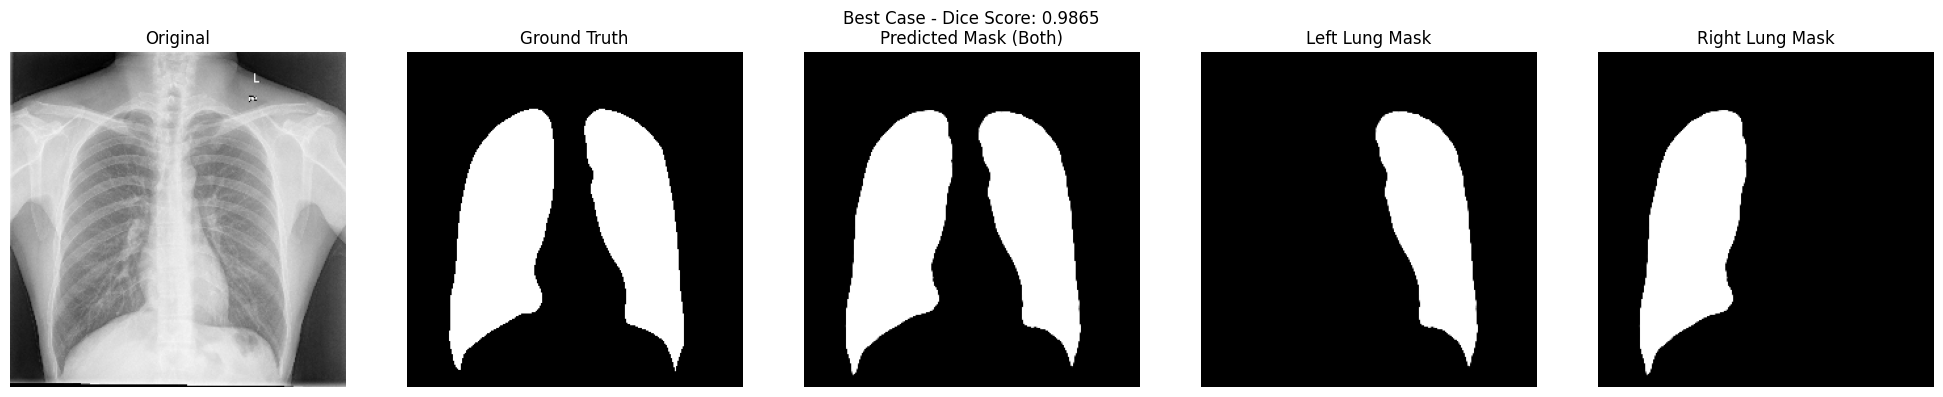

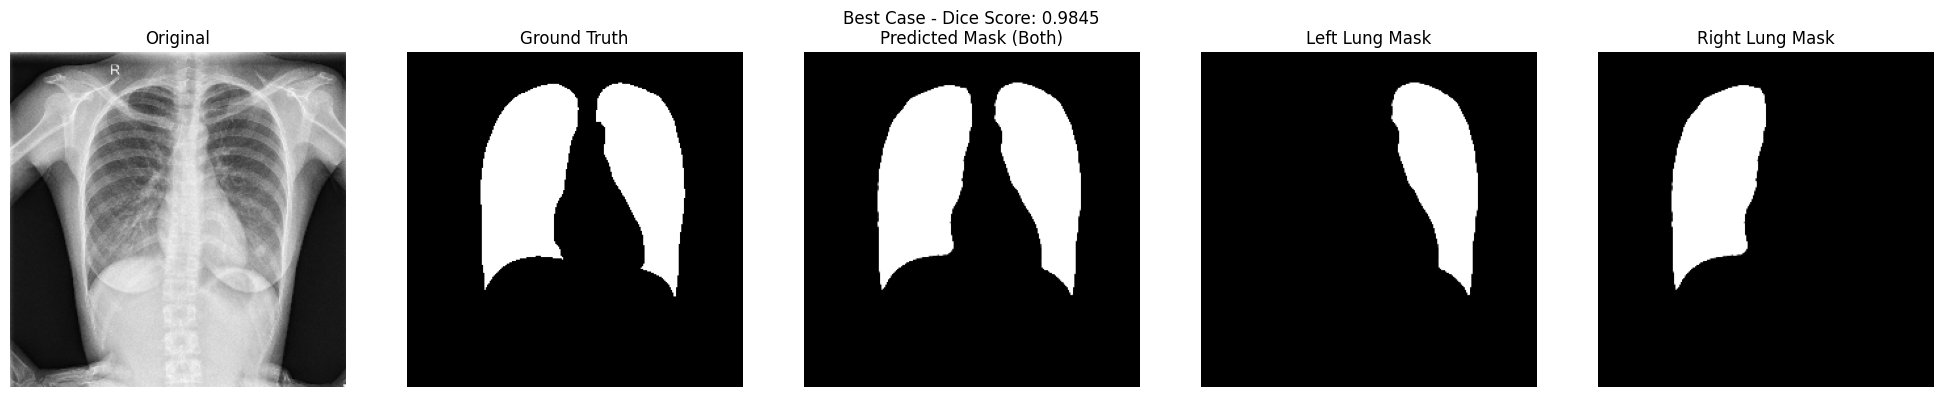

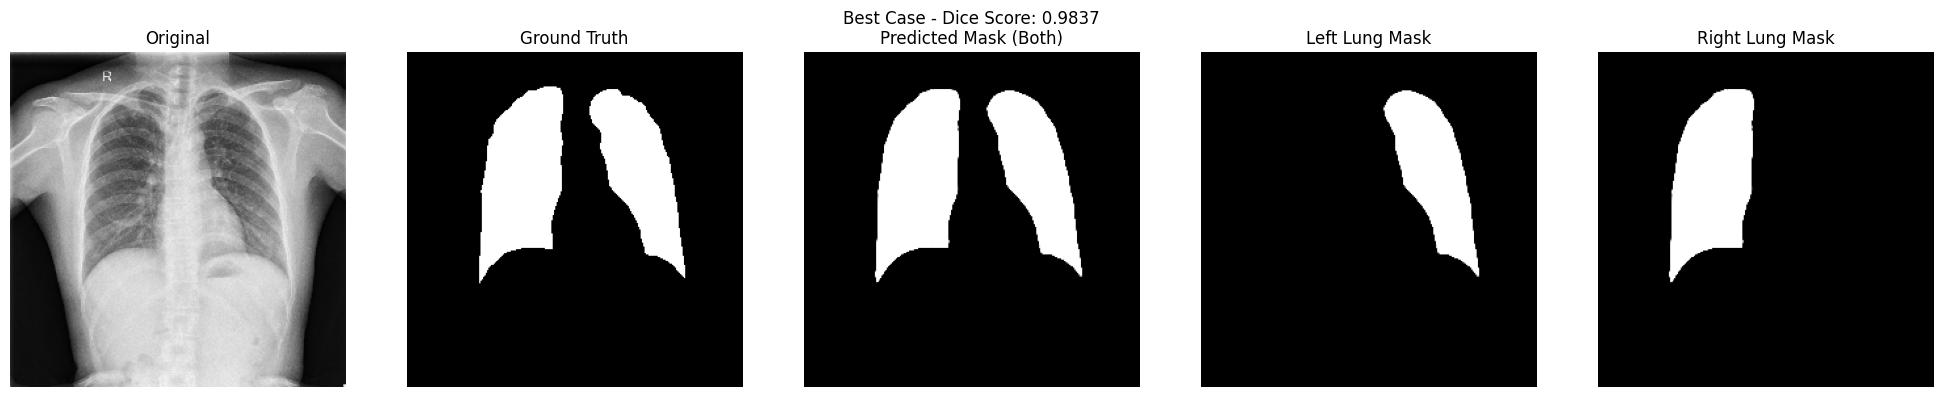

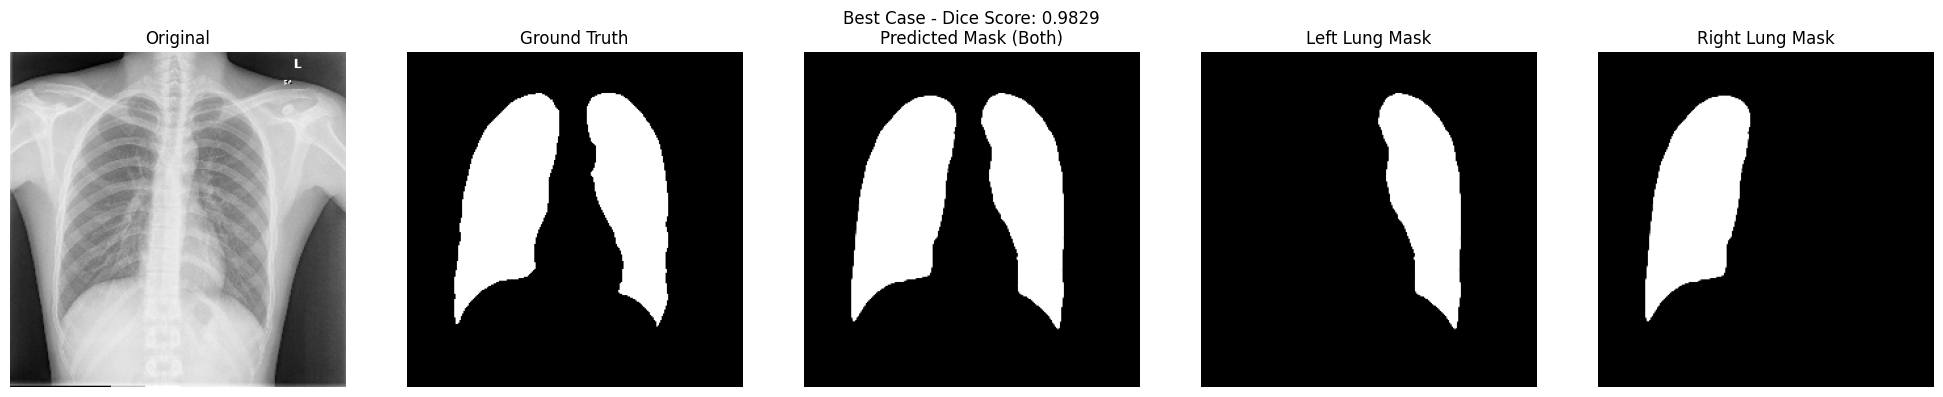

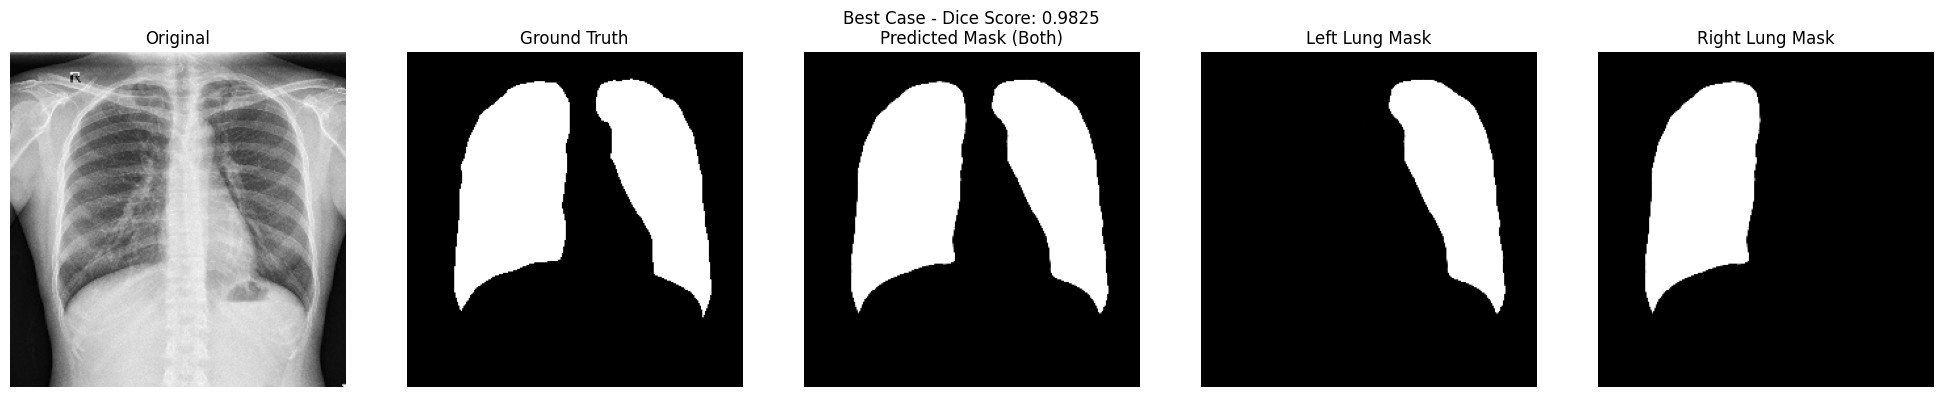

In [ ]:
# 테스트 데이터에 대한 예측
y_pred = model.predict(X_test)

# 각 이미지별 평균 Dice coefficient 계산
dice_scores = []
for i in range(len(X_test)):
    # 왼쪽과 오른쪽 폐에 대한 Dice 계산 (배경 제외)
    y_true_left = np.expand_dims(y_test[i,:,:,1], axis=0)
    y_true_right = np.expand_dims(y_test[i,:,:,2], axis=0)
    y_pred_left = np.expand_dims(y_pred[i,:,:,1], axis=0)
    y_pred_right = np.expand_dims(y_pred[i,:,:,2], axis=0)

    # Dice 계산
    left_dice = dice_coef(y_true_left, y_pred_left).numpy()
    right_dice = dice_coef(y_true_right, y_pred_right).numpy()
    avg_dice = (left_dice + right_dice) / 2
    dice_scores.append((i, avg_dice))

# Dice score 기준으로 정렬
sorted_dice = sorted(dice_scores, key=lambda x: x[1])
worst_5 = sorted_dice[:5]  # 하위 5개
best_5 = sorted_dice[-5:]  # 상위 5개

def visualize_results(indices, title):
    for idx, score in indices:
        plt.figure(figsize=(20,4))
        plt.suptitle(f"{title} - Dice Score: {score:.4f}")

        plt.subplot(1,5,1)
        plt.title("Original")
        plt.imshow(X_test[idx])
        plt.axis('off')

        plt.subplot(1,5,2)
        plt.title("Ground Truth")
        plt.imshow(y_test[idx][:,:,1] + y_test[idx][:,:,2], 'gray')
        plt.axis('off')

        plt.subplot(1,5,3)
        plt.title("Predicted Mask (Both)")
        plt.imshow(y_pred[idx][:,:,1] + y_pred[idx][:,:,2], 'gray')
        plt.axis('off')

        plt.subplot(1,5,4)
        plt.title("Left Lung Mask")
        plt.imshow(y_pred[idx][:,:,1], 'gray')
        plt.axis('off')

        plt.subplot(1,5,5)
        plt.title("Right Lung Mask")
        plt.imshow(y_pred[idx][:,:,2], 'gray')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

# 시각화 실행
print("=== Worst 5 Cases ===")
visualize_results(worst_5, "Worst Case")

print("\n=== Best 5 Cases ===")
visualize_results(best_5[::-1], "Best Case")  # 역순으로 출력 (가장 좋은 것부터)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Training Dice Coefficient: 0.9693


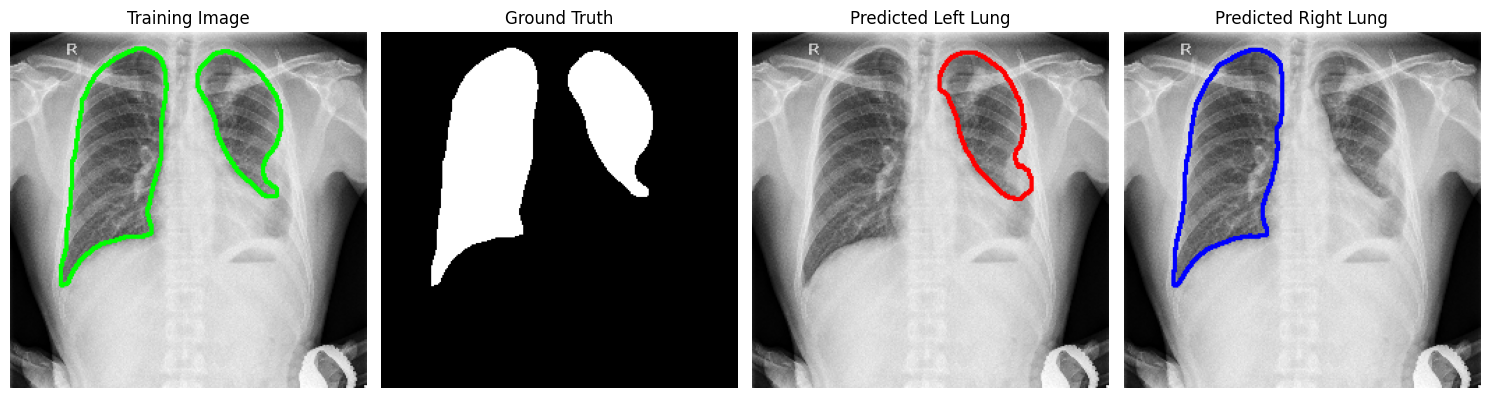

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Validation Dice Coefficient: 0.9789


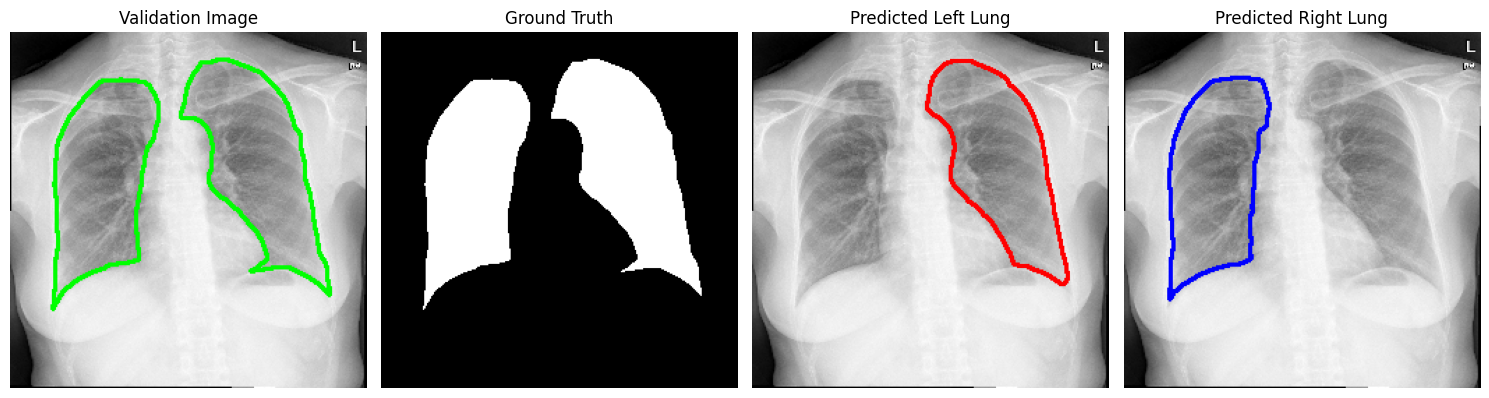

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Test Dice Coefficient: 0.9583


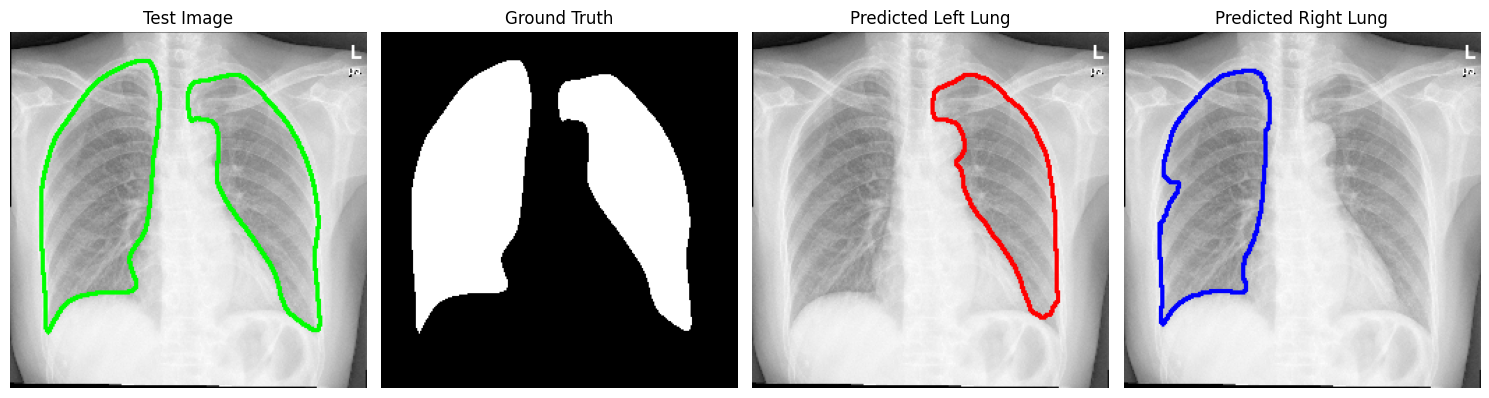

In [ ]:
def plotPredictions(X_train_, y_train_, X_valid_, y_valid_, X_test_, y_test_, model):
    def plot_sample(X, y, pred, title_prefix):
        plt.figure(figsize=(15,5))

        # 원본 이미지
        plt.subplot(1,4,1)
        plt.title(f"{title_prefix} Image")
        img_display = X[0].copy()

        # Ground Truth 윤곽선 (초록색)
        true_mask = (y[0,:,:,1] + y[0,:,:,2]).astype(np.uint8)
        true_contours, _ = cv2.findContours(true_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(img_display, true_contours, -1, (0,1,0), 2)  # 초록색 윤곽선

        plt.imshow(img_display)
        plt.axis('off')

        # 실제 마스크 (전체 폐)
        plt.subplot(1,4,2)
        plt.title("Ground Truth")
        plt.imshow(true_mask, 'gray')
        plt.axis('off')

        # 예측 마스크 (왼쪽 폐)
        plt.subplot(1,4,3)
        plt.title("Predicted Left Lung")
        left_pred = (pred[0,:,:,1] > 0.5).astype(np.uint8)  # 임계값 0.5로 이진화
        left_contours, _ = cv2.findContours(left_pred, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        img_left = X[0].copy()
        cv2.drawContours(img_left, left_contours, -1, (1,0,0), 2)  # 빨간색 윤곽선
        plt.imshow(img_left)
        plt.axis('off')

        # 예측 마스크 (오른쪽 폐)
        plt.subplot(1,4,4)
        plt.title("Predicted Right Lung")
        right_pred = (pred[0,:,:,2] > 0.5).astype(np.uint8)  # 임계값 0.5로 이진화
        right_contours, _ = cv2.findContours(right_pred, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        img_right = X[0].copy()
        cv2.drawContours(img_right, right_contours, -1, (0,0,1), 2)  # 파란색 윤곽선
        plt.imshow(img_right)
        plt.axis('off')

        plt.tight_layout()
        plt.show()

    # 학습 데이터에서 랜덤 샘플 예측
    ix = np.random.randint(0, len(X_train_))
    input_ = X_train_[ix:ix+1]
    mask_ = y_train_[ix:ix+1]
    preds_train = model.predict(input_)
    ret = model.evaluate(input_, mask_,verbose=0)
    print(f"Training Dice Coefficient: {ret[1]:.4f}")
    plot_sample(input_, mask_, preds_train, "Training")

    # 검증 데이터에서 랜덤 샘플 예측
    ix = np.random.randint(0, len(X_valid_))
    input_ = X_valid_[ix:ix+1]
    mask_ = y_valid_[ix:ix+1]
    preds_valid = model.predict(input_)
    ret=model.evaluate(input_, mask_,verbose=0)
    print(f"Validation Dice Coefficient: {ret[1]:.4f}")
    plot_sample(input_, mask_, preds_valid, "Validation")

    # 테스트 데이터에서 랜덤 샘플 예측
    ix = np.random.randint(0, len(X_test_))
    input_ = X_test_[ix:ix+1]
    mask_ = y_test_[ix:ix+1]
    preds_test = model.predict(input_)
    ret=model.evaluate(input_, mask_,verbose=0)
    print(f"Test Dice Coefficient: {ret[1]:.4f}")
    plot_sample(input_, mask_, preds_test, "Test")

#모델 예측 결과 시각화
plotPredictions(X_train, y_train, X_valid, y_valid, X_test, y_test, model)

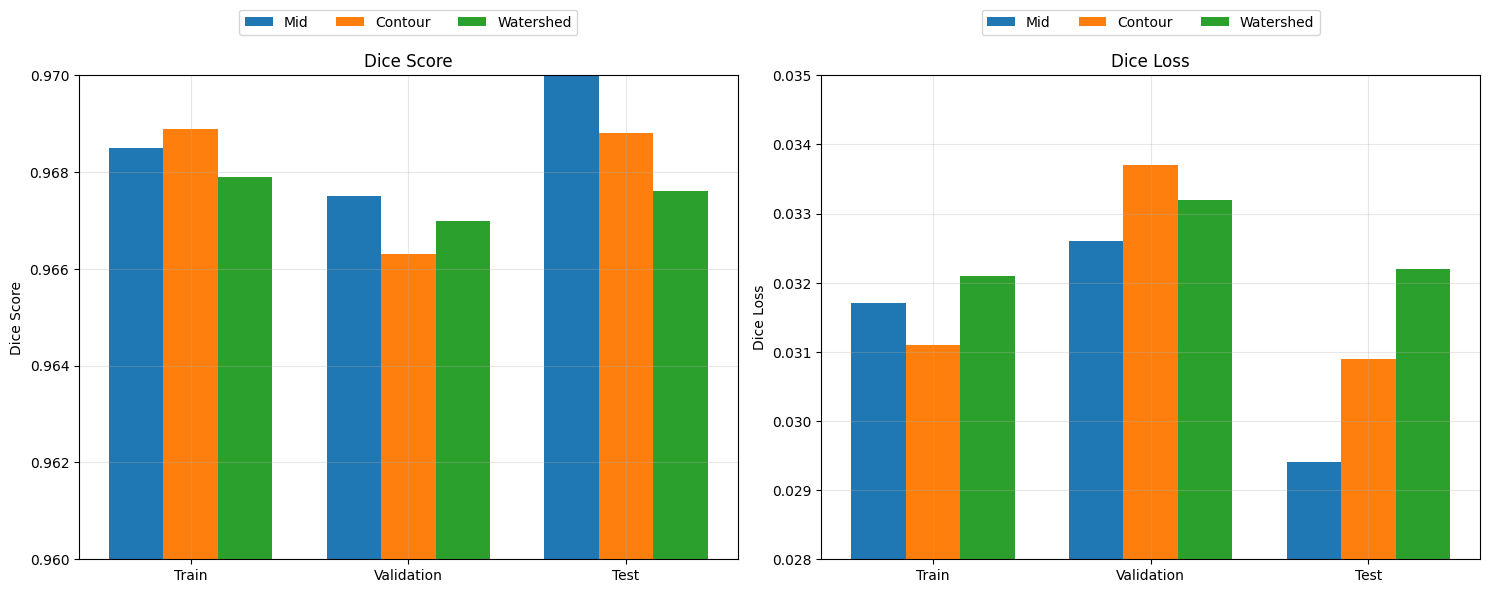

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 데이터 정의
methods = ['Mid', 'Contour', 'Watershed']
datasets = ['Train', 'Validation', 'Test']

dice_scores = np.array([
    [0.9685, 0.9675, 0.9702],  # Mid
    [0.9689, 0.9663, 0.9688],  # Contour
    [0.9679, 0.9670, 0.9676]   # Watershed
])

dice_losses = np.array([
    [0.0317, 0.0326, 0.0294],  # Mid
    [0.0311, 0.0337, 0.0309],  # Contour
    [0.0321, 0.0332, 0.0322]   # Watershed
])

# 그래프 생성
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Dice Score 그래프
x = np.arange(len(datasets))
width = 0.25

for i in range(len(methods)):
    ax1.bar(x + i*width, dice_scores[i], width, label=methods[i])

ax1.set_ylabel('Dice Score')
ax1.set_title('Dice Score')
ax1.set_xticks(x + width)
ax1.set_xticklabels(datasets)
ax1.legend(bbox_to_anchor=(0.5, 1.15), loc='upper center', ncol=3)  # 범례 위치 수정
ax1.grid(True, alpha=0.3)
# Dice Score y축 범위 설정 (0.96 ~ 0.975)
ax1.set_ylim(0.96, 0.97)

# Dice Loss 그래프
for i in range(len(methods)):
    ax2.bar(x + i*width, dice_losses[i], width, label=methods[i])

ax2.set_ylabel('Dice Loss')
ax2.set_title('Dice Loss')
ax2.set_xticks(x + width)
ax2.set_xticklabels(datasets)
ax2.legend(bbox_to_anchor=(0.5, 1.15), loc='upper center', ncol=3)  # 범례 위치 수정
ax2.grid(True, alpha=0.3)
# Dice Loss y축 범위 설정 (0.028 ~ 0.035)
ax2.set_ylim(0.028, 0.035)

plt.tight_layout()
plt.show()